# Klasyfikacja Emocji z SMOTE - WESAD Dataset

## Plan analizy

Ten notebook wykonuje kompletną analizę klasyfikacji emocji z danych WESAD zgodnie z następującym planem:

1. **Import bibliotek** - numpy, pandas, matplotlib, seaborn, scikit-learn, imblearn
2. **Wczytanie danych** - CSV/PKL z WESAD, sprawdzenie rozkładu klas
3. **Segmentacja danych** - sliding windows z ekstrakcją cech (mean, std, min, max, range, RMS, kurtosis, skewness, RMSSD, slope, respiration rate)
4. **Encoding i skalowanie** - LabelEncoder dla targetu, StandardScaler dla cech
5. **Podział Train/Test** - **Subject-wise split** (całe osoby do train/test, nie dzielimy okien)
6. **Balansowanie** - SMOTE na train, weryfikacja balansu
7. **Trenowanie modeli** - Logistic Regression, Random Forest, SVM, XGBoost
8. **Ewaluacja** - confusion matrix, accuracy, balanced accuracy, macro F1, per-class metrics
9. **Porównanie z baseline** - DummyClassifier
10. **Wnioski i raport** - wybór najlepszego modelu, analiza wyników
11. **Wizualizacje** - wykresy rozkładu klas, metryk, confusion matrices

## ⚠️ WAŻNE: Subject-wise Split

- **Całe dane jednej osoby** trafiają albo do train, albo do test
- **Nigdy nie dzielimy** okien z tej samej osoby między train i test
- To zapewnia **realistyczną generalizację** na nowych osobach


In [1]:
# ============================================================================
# KROK 1: IMPORT BIBLIOTEK
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    balanced_accuracy_score, f1_score, precision_score, recall_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

# XGBoost (opcjonalnie)
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost niedostępny - pomijam w analizie")

# Imbalanced-learn (SMOTE)
try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
except ImportError:
    IMBLEARN_AVAILABLE = False
    print("❌ imbalanced-learn niedostępny - zainstaluj: pip install imbalanced-learn")

# Scipy dla sygnałów
from scipy.signal import resample
from scipy import stats

# TensorFlow/Keras dla modeli time series (LSTM)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.utils import to_categorical
    TENSORFLOW_AVAILABLE = True
    print("✅ TensorFlow/Keras dostępny - modele time series będą dostępne")
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("⚠️ TensorFlow/Keras niedostępny - modele time series nie będą dostępne")
    print("   Zainstaluj: pip install tensorflow")

print("✅ Wszystkie biblioteki zaimportowane pomyślnie!")


: 

## KROK 2: WCZYTYWANIE DANYCH

Wczytujemy dane WESAD z plików CSV i PKL. Sprawdzamy rozkład klas.


In [ ]:
# ============================================================================
# KROK 2: WCZYTYWANIE DANYCH
# ============================================================================

# Ścieżki
RAW_ROOT = Path("/Users/turfian/Downloads/archive (4)/WESAD")
PROJECT_ROOT = Path("/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep")

# Parametry
TARGET_FS = 32.0
MAX_DURATION = pd.Timedelta(minutes=40)
DEFAULT_SUBJECTS = ["S2", "S3", "S4", "S5", "S6", "S7"]

# Mapowanie faz do klas (zgodnie z rzeczywistymi nazwami faz w WESAD)
PHASE_TO_CLASS = {
    "Base": "baseline",
    "Medi 1": "baseline",
    "Medi 2": "baseline",
    "TSST": "stress",
    "sRead": "stress",
    "fRead": "stress",
    "Fun": "amusement",
    # Alternatywne nazwy (na wypadek różnic w plikach)
    "Stress": "stress",
    "Amusement": "amusement",
    "Meditation": "baseline",
}

# Funkcje pomocnicze do parsowania
def build_time_index(length: int, start_ts: float, fs: float) -> pd.Series:
    """Buduje indeks czasowy dla sygnału"""
    start = pd.to_datetime(start_ts, unit="s", utc=True)
    offsets = pd.to_timedelta(np.arange(length) / fs, unit="s")
    return start + offsets

def load_sensor_for_subject(subject_path: Path, sensor_name: str) -> pd.DataFrame:
    """Wczytuje dane z sensora (CSV)"""
    file_path = subject_path / f"{sensor_name}.csv"
    if not file_path.exists():
        return pd.DataFrame()
    
    header = pd.read_csv(file_path, nrows=2, header=None)
    start_ts = float(header.iloc[0, 0])
    fs = float(header.iloc[1, 0])
    
    column_names = {
        "ACC": ["acc_x", "acc_y", "acc_z"],
        "EDA": ["eda"],
        "BVP": ["bvp"],
        "TEMP": ["temp"],
        "HR": ["hr"],
    }.get(sensor_name, [sensor_name.lower()])
    
    data = pd.read_csv(file_path, skiprows=2, header=None, names=column_names)
    data.insert(0, "timestamp", build_time_index(len(data), start_ts, fs))
    data.attrs.update({"start_ts": start_ts, "fs": fs})
    return data

def load_wesad_pickle(subject: str, raw_root: Path = RAW_ROOT) -> dict:
    """Wczytuje dane z pliku PKL"""
    pkl_path = raw_root / subject / f"{subject}.pkl"
    if not pkl_path.exists():
        raise FileNotFoundError(f"Brak pliku {pkl_path}")
    with pkl_path.open("rb") as handle:
        return pickle.load(handle, encoding="latin1")

def load_tags_for_subject(subject_path: Path) -> pd.DataFrame:
    """Wczytuje tagi (etykiety) dla subjecta"""
    path = subject_path / "tags.csv"
    if not path.exists() or path.stat().st_size == 0:
        return pd.DataFrame(columns=["timestamp", "tag"])
    tags = pd.read_csv(path, header=None, names=["timestamp"])
    tags["timestamp"] = pd.to_datetime(tags["timestamp"], unit="s", utc=True)
    tags["tag"] = 1
    return tags

def build_phase_protocol_for_subject(subject: str, session_start: pd.Timestamp, raw_root: Path = RAW_ROOT) -> pd.DataFrame:
    """Buduje protokół faz dla subjecta z pliku *_quest.csv"""
    quest_path = raw_root / subject / f"{subject}_quest.csv"
    if not quest_path.exists():
        return pd.DataFrame(columns=["phase", "start", "end", "duration_s"])
    
    lines = [line.strip() for line in quest_path.read_text().splitlines() if line.strip()]
    
    def _extract_values(lines, prefix):
        for line in lines:
            if line.startswith(prefix):
                return [token for token in line.split(";")[1:] if token]
        return []
    
    names = _extract_values(lines, "# ORDER")
    starts = _extract_values(lines, "# START")
    ends = _extract_values(lines, "# END")
    
    phases = []
    limit = min(len(names), len(starts), len(ends))
    for idx in range(limit):
        try:
            start_sec = float(starts[idx])
            end_sec = float(ends[idx])
            phase_name = names[idx].strip()
            phases.append({
                "phase": phase_name,
                "start": session_start + pd.to_timedelta(start_sec, unit="s"),
                "end": session_start + pd.to_timedelta(end_sec, unit="s"),
                "duration_s": end_sec - start_sec
            })
        except (ValueError, IndexError):
            continue
    
    return pd.DataFrame(phases)

def assign_phase_labels(timestamps: pd.Series, phases: pd.DataFrame) -> pd.Series:
    """Przypisuje etykiety faz do timestampów"""
    if phases.empty:
        return pd.Series(["unknown"] * len(timestamps), index=timestamps.index)
    intervals = pd.IntervalIndex.from_arrays(phases["start"], phases["end"], closed="left")
    labels = phases["phase"].to_list()
    idx = intervals.get_indexer(timestamps)
    label_array = np.array(labels, dtype=object)
    mapped = np.where(idx >= 0, label_array[idx], "unknown")
    return pd.Series(mapped, index=timestamps.index)

def resample_signal(array, src_fs: float, target_fs: float, target_len: int) -> np.ndarray:
    """Resampluje sygnał do docelowej częstotliwości"""
    if array.ndim == 1:
        array = array[:, None]
    expected_len = int(src_fs * MAX_DURATION.total_seconds())
    trimmed = array[:expected_len]
    if len(trimmed) == 0:
        return np.full((target_len, array.shape[1]), np.nan)
    return resample(trimmed, target_len, axis=0)

# Wczytanie danych dla wszystkich subjectów
print("=" * 80)
print("KROK 2: WCZYTYWANIE DANYCH")
print("=" * 80)

all_subjects_data = []

for subject in DEFAULT_SUBJECTS:
    print(f"\n📂 Wczytuję dane dla {subject}...")
    subject_path = RAW_ROOT / subject / f"{subject}_E4_Data"
    
    if not subject_path.exists():
        print(f"  ⚠️ Brak folderu {subject_path} - pomijam")
        continue
    
    # Wczytaj sygnały z nadgarstka (CSV)
    wrist_data = {}
    for sensor in ["ACC", "EDA", "BVP", "TEMP"]:
        sensor_df = load_sensor_for_subject(subject_path, sensor)
        if not sensor_df.empty:
            wrist_data[sensor.lower()] = sensor_df
    
    # Sprawdź czy mamy dane
    if not wrist_data:
        print(f"  ⚠️ Brak danych z nadgarstka - pomijam")
        continue
    
    # Użyj timestamp z pierwszego sensora jako session_start
    first_sensor = list(wrist_data.values())[0]
    if len(first_sensor) == 0:
        print(f"  ⚠️ Pusty sensor - pomijam")
        continue
    
    session_start = first_sensor["timestamp"].iloc[0]
    
    # Wczytaj protokół faz
    phases = build_phase_protocol_for_subject(subject, session_start)
    
    # Połącz dane nadgarstka
    if wrist_data:
        # Użyj BVP jako referencji czasowej
        if "bvp" in wrist_data:
            base_df = wrist_data["bvp"][["timestamp"]].copy()
            for sensor_name, sensor_df in wrist_data.items():
                if sensor_name != "bvp":
                    # Resample do częstotliwości BVP
                    merged = pd.merge_asof(
                        base_df.sort_values("timestamp"),
                        sensor_df[["timestamp"] + [col for col in sensor_df.columns if col != "timestamp"]].sort_values("timestamp"),
                        on="timestamp",
                        direction="nearest",
                        tolerance=pd.Timedelta(seconds=1)
                    )
                    for col in sensor_df.columns:
                        if col != "timestamp":
                            base_df[col] = merged[col].values
            
            # Dodaj pozostałe kolumny z BVP
            for col in wrist_data["bvp"].columns:
                if col != "timestamp" and col not in base_df.columns:
                    base_df[col] = wrist_data["bvp"][col].values
            
            # Resample do docelowej częstotliwości
            target_len = int(MAX_DURATION.total_seconds() * TARGET_FS)
            timestamps = session_start + pd.to_timedelta(np.arange(target_len) / TARGET_FS, unit="s")
            
            # Resample każdej kolumny
            resampled_data = {}
            for col in base_df.columns:
                if col != "timestamp":
                    original_values = base_df[col].values
                    if len(original_values) > 0:
                        resampled = resample_signal(original_values, wrist_data["bvp"].attrs["fs"], TARGET_FS, target_len)
                        resampled_data[col] = resampled.flatten() if resampled.ndim > 1 else resampled
                    else:
                        resampled_data[col] = np.full(target_len, np.nan)
            
            # Stwórz DataFrame
            subject_df = pd.DataFrame(resampled_data)
            subject_df.insert(0, "timestamp", timestamps)
            
            # Dodaj etykiety faz
            subject_df["phase"] = assign_phase_labels(subject_df["timestamp"], phases)
            subject_df["label"] = subject_df["phase"].map(PHASE_TO_CLASS).fillna("unknown")
            subject_df["subject"] = subject
            
            # Sprawdź rozkład faz i klas dla tego subjecta
            phase_dist = subject_df["phase"].value_counts()
            label_dist = subject_df["label"].value_counts()
            print(f"    Fazy: {dict(phase_dist)}")
            print(f"    Klasy: {dict(label_dist)}")
            
            all_subjects_data.append(subject_df)
            print(f"  ✅ Wczytano {len(subject_df)} próbek")

# Połącz wszystkie dane
if all_subjects_data:
    full_data = pd.concat(all_subjects_data, ignore_index=True)
    print(f"\n{'='*80}")
    print("PODSUMOWANIE WCZYTYWANIA DANYCH")
    print(f"{'='*80}")
    print(f"✅ Wczytano dane dla {len(all_subjects_data)} subjectów")
    print(f"   Łączna liczba próbek: {len(full_data)}")
    
    print(f"\n📊 SZCZEGÓŁOWY ROZKŁAD KLAS PER SUBJECT:")
    print("-" * 80)
    for subject in full_data["subject"].unique():
        subject_data = full_data[full_data["subject"] == subject]
        print(f"\n  {subject}:")
        label_dist = subject_data["label"].value_counts()
        for label in label_dist.index:
            count = label_dist[label]
            pct = (count / len(subject_data) * 100) if len(subject_data) > 0 else 0
            print(f"    {label:12s}: {count:6d} próbek ({pct:6.2f}%)")
    
    print(f"\n📊 ROZKŁAD FAZ PER SUBJECT:")
    print("-" * 80)
    for subject in full_data["subject"].unique():
        subject_data = full_data[full_data["subject"] == subject]
        print(f"\n  {subject}:")
        phase_dist = subject_data["phase"].value_counts()
        for phase in phase_dist.index:
            count = phase_dist[phase]
            pct = (count / len(subject_data) * 100) if len(subject_data) > 0 else 0
            print(f"    {phase:15s}: {count:6d} próbek ({pct:6.2f}%)")
    
    print(f"\n📊 GLOBALNY ROZKŁAD KLAS (wszystkie subjecty):")
    print("-" * 80)
    class_dist = full_data["label"].value_counts()
    for label in class_dist.index:
        count = class_dist[label]
        pct = (count / len(full_data) * 100) if len(full_data) > 0 else 0
        print(f"   {label:12s}: {count:6d} próbek ({pct:6.2f}%)")
    
    print(f"\n📊 GLOBALNY ROZKŁAD FAZ (wszystkie subjecty):")
    print("-" * 80)
    phase_dist = full_data["phase"].value_counts()
    for phase in phase_dist.index:
        count = phase_dist[phase]
        pct = (count / len(full_data) * 100) if len(full_data) > 0 else 0
        print(f"   {phase:15s}: {count:6d} próbek ({pct:6.2f}%)")
    
    print(f"\n📊 KOLUMNY W DANYCH:")
    print("-" * 80)
    print(f"   Kolumny sygnałów: {[col for col in full_data.columns if col not in ['timestamp', 'phase', 'label', 'subject']]}")
    print(f"   Liczba kolumn sygnałów: {len([col for col in full_data.columns if col not in ['timestamp', 'phase', 'label', 'subject']])}")
    
    print(f"\n📊 KILKA PIERWSZYCH WIERSZY:")
    print("-" * 80)
    print(full_data.head(10))
    
    print(f"\n📊 STATYSTYKI CZASOWE:")
    print("-" * 80)
    print(f"   Najwcześniejszy timestamp: {full_data['timestamp'].min()}")
    print(f"   Najpóźniejszy timestamp: {full_data['timestamp'].max()}")
    print(f"   Czas trwania: {(full_data['timestamp'].max() - full_data['timestamp'].min()).total_seconds() / 60:.2f} minut")
    
    print(f"\n✅ WCZYTYWANIE DANYCH ZAKOŃCZONE POMYŚLNIE!")
else:
    print("❌ Nie wczytano żadnych danych!")
    raise ValueError("Brak danych do analizy")


KROK 2: WCZYTYWANIE DANYCH

📂 Wczytuję dane dla S2...


    Fazy: {'unknown': 75098, 'Base': 616, 'TSST': 344, 'Medi 1': 221, 'Medi 2': 216, 'Fun': 200, 'sRead': 53, 'fRead': 52}
    Klasy: {'unknown': 75098, 'baseline': 1053, 'stress': 449, 'amusement': 200}
  ✅ Wczytano 76800 próbek

📂 Wczytuję dane dla S3...
    Fazy: {'unknown': 75040, 'Base': 627, 'TSST': 352, 'Medi 1': 225, 'Medi 2': 217, 'Fun': 203, 'bRead': 55, 'fRead': 41, 'sRead': 40}
    Klasy: {'unknown': 75095, 'baseline': 1069, 'stress': 433, 'amusement': 203}
  ✅ Wczytano 76800 próbek

📂 Wczytuję dane dla S4...
    Fazy: {'unknown': 75009, 'Base': 633, 'TSST': 350, 'Medi 1': 239, 'Medi 2': 223, 'Fun': 215, 'fRead': 49, 'bRead': 48, 'sRead': 34}
    Klasy: {'unknown': 75057, 'baseline': 1095, 'stress': 433, 'amusement': 215}
  ✅ Wczytano 76800 próbek

📂 Wczytuję dane dla S5...
    Fazy: {'unknown': 75032, 'Base': 646, 'TSST': 354, 'Medi 1': 223, 'Medi 2': 223, 'Fun': 203, 'bRead': 43, 'fRead': 42, 'sRead': 34}
    Klasy: {'unknown': 75075, 'baseline': 1092, 'stress': 430, 'amu

## KROK 3: SEGMENTACJA DANYCH (SLIDING WINDOWS)

Tworzymy okna czasowe i wyciągamy statystyczne cechy z każdego okna.


In [ ]:
# ============================================================================
# KROK 3: SEGMENTACJA DANYCH (SLIDING WINDOWS)
# ============================================================================

# Sprawdź dostępność zmiennych
if 'full_data' not in globals():
    print("\n❌❌❌ BŁĄD: Najpierw uruchom KROK 2!")
    raise NameError("full_data nie jest zdefiniowane - uruchom najpierw KROK 2")

# Parametry segmentacji
WINDOW_SIZE_SECONDS = 5  # Rozmiar okna w sekundach
STEP_SIZE_SECONDS = 2.5  # Krok (50% overlap)
WINDOW_SIZE = int(WINDOW_SIZE_SECONDS * TARGET_FS)  # Rozmiar okna w próbkach
STEP_SIZE = int(STEP_SIZE_SECONDS * TARGET_FS)  # Krok w próbkach

print("=" * 80)
print("KROK 3: SEGMENTACJA DANYCH (SLIDING WINDOWS)")
print("=" * 80)
print(f"  Rozmiar okna: {WINDOW_SIZE_SECONDS} sekund ({WINDOW_SIZE} próbek)")
print(f"  Krok: {STEP_SIZE_SECONDS} sekund ({STEP_SIZE} próbek)")
print(f"  Overlap: {(1 - STEP_SIZE_SECONDS/WINDOW_SIZE_SECONDS)*100:.1f}%")

# Funkcje do ekstrakcji cech
def compute_rms(signal):
    """Oblicza RMS (Root Mean Square)"""
    return np.sqrt(np.mean(signal**2))

def compute_kurtosis(signal):
    """Oblicza kurtozę"""
    if len(signal) < 4:
        return 0.0
    return stats.kurtosis(signal, nan_policy='omit')

def compute_skewness(signal):
    """Oblicza skośność"""
    if len(signal) < 3:
        return 0.0
    return stats.skew(signal, nan_policy='omit')

def compute_rmssd(signal):
    """Oblicza RMSSD (Root Mean Square of Successive Differences) - dla HRV"""
    if len(signal) < 2:
        return 0.0
    diff = np.diff(signal)
    return np.sqrt(np.mean(diff**2))

def compute_slope(signal):
    """Oblicza nachylenie (slope) - trend liniowy"""
    if len(signal) < 2:
        return 0.0
    x = np.arange(len(signal))
    coeffs = np.polyfit(x, signal, 1)
    return coeffs[0]

def compute_respiration_rate(signal, fs=TARGET_FS):
    """Oblicza tempo oddechu (dla sygnału respiracji)"""
    if len(signal) < int(fs * 2):  # Minimum 2 sekundy
        return 0.0
    # Znajdź peaki (uproszczone)
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(signal, distance=int(fs * 0.5))  # Minimum 0.5s między peakami
    if len(peaks) < 2:
        return 0.0
    # Oblicz średni czas między peakami
    peak_intervals = np.diff(peaks) / fs
    avg_interval = np.mean(peak_intervals)
    if avg_interval > 0:
        return 60.0 / avg_interval  # Oddechy na minutę
    return 0.0

def extract_features_from_window(window_data):
    """Wyciąga cechy statystyczne z okna"""
    features = {}
    
    # Kolumny sygnałów (pomijamy timestamp, phase, label, subject)
    signal_cols = [col for col in window_data.columns 
                   if col not in ["timestamp", "phase", "label", "subject"]]
    
    for col in signal_cols:
        signal = window_data[col].values
        signal_clean = signal[~np.isnan(signal)]
        
        if len(signal_clean) == 0:
            # Jeśli wszystkie wartości są NaN, ustaw wszystkie cechy na 0
            features[f"{col}_mean"] = 0.0
            features[f"{col}_std"] = 0.0
            features[f"{col}_min"] = 0.0
            features[f"{col}_max"] = 0.0
            features[f"{col}_range"] = 0.0
            features[f"{col}_rms"] = 0.0
            features[f"{col}_kurtosis"] = 0.0
            features[f"{col}_skewness"] = 0.0
            features[f"{col}_rmssd"] = 0.0
            features[f"{col}_slope"] = 0.0
            continue
        
        # Podstawowe statystyki
        features[f"{col}_mean"] = np.mean(signal_clean)
        features[f"{col}_std"] = np.std(signal_clean) if len(signal_clean) > 1 else 0.0
        features[f"{col}_min"] = np.min(signal_clean)
        features[f"{col}_max"] = np.max(signal_clean)
        features[f"{col}_range"] = features[f"{col}_max"] - features[f"{col}_min"]
        
        # Zaawansowane cechy
        features[f"{col}_rms"] = compute_rms(signal_clean)
        features[f"{col}_kurtosis"] = compute_kurtosis(signal_clean)
        features[f"{col}_skewness"] = compute_skewness(signal_clean)
        features[f"{col}_rmssd"] = compute_rmssd(signal_clean)
        features[f"{col}_slope"] = compute_slope(signal_clean)
        
        # Tempo oddechu (tylko dla kolumn związanych z oddechem)
        if "resp" in col.lower() or "breath" in col.lower():
            features[f"{col}_respiration_rate"] = compute_respiration_rate(signal_clean)
    
    return features

# Segmentacja sliding window
print(f"\n🔧 Wykonuję segmentację sliding window...")

segmented_data = []
groups = []  # Dla subject-wise split

for subject in full_data["subject"].unique():
    subject_data = full_data[full_data["subject"] == subject].copy()
    subject_data = subject_data.sort_values("timestamp").reset_index(drop=True)
    
    # Segmentacja
    n_samples = len(subject_data)
    for start_idx in range(0, n_samples - WINDOW_SIZE + 1, STEP_SIZE):
        end_idx = start_idx + WINDOW_SIZE
        window = subject_data.iloc[start_idx:end_idx].copy()
        
        # Wyciągnij cechy
        features = extract_features_from_window(window)
        
        # Etykieta okna (mode z okna)
        label_counts = window["label"].value_counts()
        window_label = label_counts.index[0] if len(label_counts) > 0 else "unknown"
        
        # Dodaj metadane
        features["label"] = window_label
        features["subject"] = subject
        features["window_start"] = start_idx
        features["window_end"] = end_idx
        
        segmented_data.append(features)
        groups.append(subject)

# Stwórz DataFrame z segmentowanych danych
segmented_df = pd.DataFrame(segmented_data)

print(f"\n{'='*80}")
print("PODSUMOWANIE SEGMENTACJI")
print(f"{'='*80}")
print(f"✅ Segmentacja zakończona!")
print(f"   Liczba okien: {len(segmented_df)}")
print(f"   Liczba cech: {len([col for col in segmented_df.columns if col not in ['label', 'subject', 'window_start', 'window_end']])}")

# Sprawdź rozkład klas przed usunięciem "unknown"
print(f"\n📊 ROZKŁAD KLAS PRZED USUNIĘCIEM 'unknown':")
print("-" * 80)
class_dist_before_clean = segmented_df["label"].value_counts()
for label in class_dist_before_clean.index:
    count = class_dist_before_clean[label]
    pct = (count / len(segmented_df) * 100) if len(segmented_df) > 0 else 0
    print(f"   {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# Usuń okna z etykietą "unknown"
segmented_df = segmented_df[segmented_df["label"] != "unknown"].copy()
print(f"\n📊 Liczba okien po usunięciu 'unknown': {len(segmented_df)}")
print(f"   Usunięto: {len(segmented_data) - len(segmented_df)} okien z etykietą 'unknown'")

# Sprawdź rozkład klas przed agregacją
print(f"\n📊 Rozkład klas PRZED agregacją:")
class_dist_before_agg = segmented_df["label"].value_counts()
print(class_dist_before_agg)

# ⚠️ WAŻNE: Agregacja klas (amusement + stress → emotion)
print(f"\n{'='*80}")
print("AGREGACJA KLAS: amusement + stress → emotion")
print(f"{'='*80}")
segmented_df["label"] = segmented_df["label"].replace({
    "amusement": "emotion",
    "stress": "emotion"
})
print(f"   ✅ Agregacja wykonana: amusement + stress → emotion")

# Użyj kolumny 'subject' z segmented_df jako groups (najprostsze i najbardziej niezawodne)
if 'subject' in segmented_df.columns:
    groups = segmented_df['subject'].tolist()
    print(f"   ✅ Utworzono groups z kolumny 'subject': {len(groups)} elementów")
else:
    print(f"   ⚠️ OSTRZEŻENIE: Brak kolumny 'subject' w segmented_df!")
    raise ValueError("Brak kolumny 'subject' w segmented_df - nie można utworzyć groups")

# Sprawdź rozkład klas po agregacji
print(f"\n📊 ROZKŁAD KLAS PO AGREGACJI:")
print("-" * 80)
class_dist_seg = segmented_df["label"].value_counts()
for label in class_dist_seg.index:
    count = class_dist_seg[label]
    pct = (count / len(segmented_df) * 100) if len(segmented_df) > 0 else 0
    print(f"   {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# Sprawdź rozkład klas per subject po agregacji
print(f"\n📊 ROZKŁAD KLAS PER SUBJECT PO AGREGACJI:")
print("-" * 80)
for subject in segmented_df["subject"].unique():
    subject_data = segmented_df[segmented_df["subject"] == subject]
    print(f"\n  {subject}:")
    label_dist = subject_data["label"].value_counts()
    for label in label_dist.index:
        count = label_dist[label]
        pct = (count / len(subject_data) * 100) if len(subject_data) > 0 else 0
        print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# Weryfikacja: czy mamy obie klasy (baseline i emotion)
unique_labels = segmented_df["label"].unique()
print(f"\n{'='*80}")
print("WERYFIKACJA KLAS PO SEGMENTACJI I AGREGACJI")
print(f"{'='*80}")
print(f"   Unikalne klasy: {unique_labels}")
print(f"   Liczba klas: {len(unique_labels)}")

if len(unique_labels) < 2:
    print(f"\n❌❌❌ BŁĄD: Tylko {len(unique_labels)} klas po segmentacji!")
    print(f"   Musimy mieć co najmniej 2 klasy (baseline i emotion) dla SMOTE!")
    print(f"   Sprawdź wczytywanie faz i mapowanie PHASE_TO_CLASS.")
    print(f"\n📊 DIAGNOSTYKA:")
    print(f"   - Sprawdź czy fazy są poprawnie wczytywane z plików *_quest.csv")
    print(f"   - Sprawdź czy mapowanie PHASE_TO_CLASS jest poprawne")
    print(f"   - Sprawdź czy assign_phase_labels działa poprawnie")
else:
    print(f"   ✅ Mamy {len(unique_labels)} klas - OK dla SMOTE")
    print(f"   ✅ Klasy: {', '.join(unique_labels)}")
    
    # Sprawdź balance ratio przed SMOTE
    if len(unique_labels) == 2:
        counts = [class_dist_seg[label] for label in unique_labels]
        balance_ratio = min(counts) / max(counts) if max(counts) > 0 else 0
        print(f"   📊 Balance ratio (przed SMOTE): {balance_ratio:.4f}")
        if balance_ratio < 0.5:
            print(f"   ⚠️ OSTRZEŻENIE: Silna nierównowaga klas (balance ratio < 0.5)")
            print(f"      SMOTE będzie musiał wygenerować dużo syntetycznych próbek")


KROK 3: SEGMENTACJA DANYCH (SLIDING WINDOWS)
  Rozmiar okna: 5 sekund (160 próbek)
  Krok: 2.5 sekund (80 próbek)
  Overlap: 50.0%

🔧 Wykonuję segmentację sliding window...



PODSUMOWANIE SEGMENTACJI
✅ Segmentacja zakończona!
   Liczba okien: 5754
   Liczba cech: 60

📊 ROZKŁAD KLAS PRZED USUNIĘCIEM 'unknown':
--------------------------------------------------------------------------------
   unknown     : 5631 próbek ( 97.9%)
   baseline    :   80 próbek (  1.4%)
   stress      :   26 próbek (  0.5%)
   amusement   :   17 próbek (  0.3%)

📊 Liczba okien po usunięciu 'unknown': 123
   Usunięto: 5631 okien z etykietą 'unknown'

📊 Rozkład klas PRZED agregacją:
label
baseline     80
stress       26
amusement    17
Name: count, dtype: int64

AGREGACJA KLAS: amusement + stress → emotion
   ✅ Agregacja wykonana: amusement + stress → emotion
   ✅ Utworzono groups z kolumny 'subject': 123 elementów

📊 ROZKŁAD KLAS PO AGREGACJI:
--------------------------------------------------------------------------------
   baseline    :   80 próbek ( 65.0%)
   emotion     :   43 próbek ( 35.0%)

📊 ROZKŁAD KLAS PER SUBJECT PO AGREGACJI:
------------------------------------------

## KROK 4: ENCODING I SKALOWANIE CECH

Kodujemy etykiety i skalujemy cechy.


In [ ]:
# ============================================================================
# KROK 4: ENCODING I SKALOWANIE CECH
# ============================================================================

# Sprawdź dostępność zmiennych
if 'segmented_df' not in globals():
    print("\n❌❌❌ BŁĄD: Najpierw uruchom KROK 3!")
    raise NameError("segmented_df nie jest zdefiniowane - uruchom najpierw KROK 3")

print("=" * 80)
print("KROK 4: ENCODING I SKALOWANIE CECH")
print("=" * 80)

# Przygotuj dane
feature_cols = [col for col in segmented_df.columns 
                if col not in ["label", "subject", "window_start", "window_end"]]
X = segmented_df[feature_cols].copy()
y = segmented_df["label"].copy()

# Usuń kolumny z samymi NaN
X = X.dropna(axis=1, how='all')

# Wypełnij pozostałe NaN zerami
X = X.fillna(0.0)

print(f"\n📊 Kształt danych:")
print(f"   X: {X.shape}")
print(f"   y: {len(y)} próbek")

# LabelEncoder dla targetu
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\n✅ LabelEncoder:")
print(f"   Klasy: {label_encoder.classes_}")
print(f"   Kodowanie: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

# StandardScaler dla cech
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print(f"\n✅ StandardScaler:")
print(f"   Cechy przeskalowane: {X_scaled.shape[1]}")
print(f"   Przykładowe wartości (pierwsze 5 cech, pierwsze 3 próbki):")
print(X_scaled.iloc[:3, :5])


KROK 4: ENCODING I SKALOWANIE CECH

📊 Kształt danych:
   X: (123, 60)
   y: 123 próbek

✅ LabelEncoder:
   Klasy: ['baseline' 'emotion']
   Kodowanie: {'baseline': 0, 'emotion': 1}

✅ StandardScaler:
   Cechy przeskalowane: 60
   Przykładowe wartości (pierwsze 5 cech, pierwsze 3 próbki):
   acc_x_mean  acc_x_std  acc_x_min  acc_x_max  acc_x_range
2    0.746109  -0.743730   1.082446   0.096562    -0.773286
3    0.752501  -0.765521   1.087307   0.096423    -0.777279
4    0.746653  -0.778669   1.101748   0.095018    -0.790038


## KROK 5: PODZIAŁ TRAIN/TEST - SUBJECT-WISE SPLIT

⚠️ **WAŻNE**: Całe dane jednej osoby trafiają albo do train, albo do test. Nie dzielimy okien z tej samej osoby między train i test.


In [ ]:
# ============================================================================
# KROK 5: PODZIAŁ TRAIN/TEST - SUBJECT-WISE SPLIT
# ============================================================================

# Sprawdź dostępność zmiennych
if 'X_scaled' not in globals() or 'y_encoded' not in globals() or 'groups' not in globals():
    print("\n❌❌❌ BŁĄD: Najpierw uruchom KROK 3 i KROK 4!")
    raise NameError("X_scaled, y_encoded lub groups nie są zdefiniowane - uruchom najpierw KROK 3 i KROK 4")

print("=" * 80)
print("KROK 5: PODZIAŁ TRAIN/TEST - SUBJECT-WISE SPLIT")
print("=" * 80)
print("⚠️ WAŻNE: Całe dane jednej osoby trafiają albo do train, albo do test")
print("⚠️ WAŻNE: Nie dzielimy okien z tej samej osoby między train i test")

# Sprawdź długości i konwertuj groups na numpy array
print(f"\n📊 Weryfikacja danych przed split:")
print(f"   X_scaled shape: {X_scaled.shape}")
print(f"   y_encoded length: {len(y_encoded)}")
print(f"   groups length: {len(groups)}")

if len(groups) != len(X_scaled) or len(groups) != len(y_encoded):
    print(f"\n❌❌❌ BŁĄD: Długości się nie zgadzają!")
    print(f"   X_scaled: {len(X_scaled)}, y_encoded: {len(y_encoded)}, groups: {len(groups)}")
    raise ValueError("Długości X_scaled, y_encoded i groups muszą być identyczne!")

# Konwertuj groups na numpy array (wymagane przez GroupShuffleSplit)
groups_array = np.array(groups)
print(f"   ✅ groups skonwertowany na numpy array: {groups_array.shape}")

# Sprawdź rozkład klas per subject (przed split)
print(f"\n📊 ROZKŁAD KLAS PER SUBJECT (przed split):")
print("-" * 80)
unique_subjects = np.unique(groups_array)
subject_class_dist = {}
for subject in unique_subjects:
    subject_mask = groups_array == subject
    subject_labels = y_encoded[subject_mask]
    subject_dist = pd.Series(label_encoder.inverse_transform(subject_labels)).value_counts()
    subject_class_dist[subject] = subject_dist
    print(f"\n  {subject}:")
    for label in subject_dist.index:
        print(f"    {label:12s}: {subject_dist[label]:4d} próbek")

# STRATIFIED SUBJECT-WISE SPLIT: Upewnij się, że w train i test są obecne obie klasy
print(f"\n{'='*80}")
print("STRATIFIED SUBJECT-WISE SPLIT")
print(f"{'='*80}")
print("⚠️ WAŻNE: Upewniamy się, że w train i test są obecne obie klasy!")
print("⚠️ WAŻNE: W train muszą być co najmniej 2 klasy (wymagane dla SMOTE)!")

# Sprawdź rozkład klas per subject (przed split)
print(f"\n📊 ROZKŁAD KLAS PER SUBJECT (przed split):")
print("-" * 80)
unique_subjects = np.unique(groups_array)
subject_class_dist = {}
for subject in unique_subjects:
    subject_mask = groups_array == subject
    subject_labels = y_encoded[subject_mask]
    subject_dist = pd.Series(label_encoder.inverse_transform(subject_labels)).value_counts()
    subject_class_dist[subject] = subject_dist
    print(f"\n  {subject}:")
    for label in subject_dist.index:
        print(f"    {label:12s}: {subject_dist[label]:4d} próbek")

# Użyj GroupShuffleSplit z wieloma próbami, aby znaleźć podział z obiema klasami w train i test
gss = GroupShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

best_train_idx = None
best_test_idx = None
best_score = -np.inf
best_train_subjects = None
best_test_subjects = None

print(f"\n🔍 Szukam najlepszego podziału (testuję {gss.n_splits} różnych podziałów)...")

for train_idx, test_idx in gss.split(X_scaled, y_encoded, groups=groups_array):
    # Sprawdź czy w train i test są obecne obie klasy
    train_classes = np.unique(y_encoded[train_idx])
    test_classes = np.unique(y_encoded[test_idx])
    
    # Wszystkie klasy muszą być w train (wymagane dla SMOTE)
    # W test powinna być co najmniej jedna klasa (ale najlepiej obie)
    if len(train_classes) >= 2:
        # Sprawdź subjecty w train i test
        train_subjects_set = set(groups_array[train_idx])
        test_subjects_set = set(groups_array[test_idx])
        
        # Oblicz "score" - preferuj podziały z obiema klasami w test i więcej subjectów
        score = len(train_classes) * 10 + len(test_classes) * 5 + len(train_subjects_set) + len(test_subjects_set)
        if score > best_score:
            best_score = score
            best_train_idx = train_idx
            best_test_idx = test_idx
            best_train_subjects = train_subjects_set
            best_test_subjects = test_subjects_set

# Jeśli nie znaleziono podziału z obiema klasami w train, rzuć błąd
if best_train_idx is None:
    print(f"\n❌❌❌ BŁĄD: Nie znaleziono podziału z co najmniej 2 klasami w train!")
    print(f"   To oznacza, że dane są zbyt niezbalansowane lub subjecty mają tylko jedną klasę.")
    print(f"   Sprawdź rozkład klas per subject powyżej.")
    raise ValueError("Nie można utworzyć podziału z co najmniej 2 klasami w train - SMOTE nie będzie działać!")

train_idx = best_train_idx
test_idx = best_test_idx

print(f"\n✅ Znaleziono najlepszy podział:")
print(f"   Score: {best_score}")
print(f"   Train subjects: {sorted(best_train_subjects)} ({len(best_train_subjects)} subjectów)")
print(f"   Test subjects: {sorted(best_test_subjects)} ({len(best_test_subjects)} subjectów)")

X_train = X_scaled.iloc[train_idx].copy()
X_test = X_scaled.iloc[test_idx].copy()
y_train = y_encoded[train_idx]
y_test = y_encoded[test_idx]
groups_train = [groups[i] for i in train_idx]
groups_test = [groups[i] for i in test_idx]

# Sprawdź które subjecty trafiły do train/test
train_subjects = set(groups_train)
test_subjects = set(groups_test)

print(f"\n✅ Podział subject-wise:")
print(f"   Train subjects: {sorted(train_subjects)} ({len(train_subjects)} subjectów)")
print(f"   Test subjects: {sorted(test_subjects)} ({len(test_subjects)} subjectów)")

# Weryfikacja: train i test subjects są rozłączne
if train_subjects & test_subjects:
    print(f"\n❌❌❌ BŁĄD: Train i test subjects się nakładają!")
    raise ValueError("Subject-wise split nie działa poprawnie!")
else:
    print(f"   ✅ Train i test subjects są rozłączne - OK")

# Sprawdź rozkład klas w train i test
print(f"\n📊 Rozkład klas w TRAIN:")
train_dist = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
for label in train_dist.index:
    count = train_dist[label]
    pct = (count / len(y_train) * 100) if len(y_train) > 0 else 0
    print(f"   {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

print(f"\n📊 Rozkład klas w TEST:")
test_dist = pd.Series(label_encoder.inverse_transform(y_test)).value_counts()
for label in test_dist.index:
    count = test_dist[label]
    pct = (count / len(y_test) * 100) if len(y_test) > 0 else 0
    print(f"   {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# Sprawdzenie liczby próbek per klasę (używając kodu użytkownika)
print(f"\n📊 SZCZEGÓŁOWE SPRAWDZENIE LICZBY PRÓBEK PER KLASĘ:")
print("-" * 80)
print("TRAIN:")
for label in np.unique(y_train):
    label_name = label_encoder.inverse_transform([label])[0]
    count = np.sum(y_train == label)
    print(f"   {label_name:12s} (kod {label}): {count:4d} próbek")

print("\nTEST:")
for label in np.unique(y_test):
    label_name = label_encoder.inverse_transform([label])[0]
    count = np.sum(y_test == label)
    print(f"   {label_name:12s} (kod {label}): {count:4d} próbek")

# Weryfikacja: czy w train są co najmniej 2 klasy (wymagane dla SMOTE)
train_unique_classes = np.unique(y_train)
test_unique_classes = np.unique(y_test)

print(f"\n✅ WERYFIKACJA KLAS:")
print(f"   Train: {len(train_unique_classes)} klas - {label_encoder.inverse_transform(train_unique_classes)}")
print(f"   Test: {len(test_unique_classes)} klas - {label_encoder.inverse_transform(test_unique_classes)}")

if len(train_unique_classes) < 2:
    print(f"\n⚠️ OSTRZEŻENIE: Tylko {len(train_unique_classes)} klas w train!")
    print(f"   SMOTE wymaga co najmniej 2 klas. Balansowanie może nie działać.")
else:
    print(f"   ✅ Train ma co najmniej 2 klasy - SMOTE może działać")

print(f"\n✅ Podział zakończony:")
print(f"   Train: {len(X_train)} próbek")
print(f"   Test: {len(X_test)} próbek")


KROK 5: PODZIAŁ TRAIN/TEST - SUBJECT-WISE SPLIT
⚠️ WAŻNE: Całe dane jednej osoby trafiają albo do train, albo do test
⚠️ WAŻNE: Nie dzielimy okien z tej samej osoby między train i test

📊 Weryfikacja danych przed split:
   X_scaled shape: (123, 60)
   y_encoded length: 123
   groups length: 123
   ✅ groups skonwertowany na numpy array: (123,)

📊 ROZKŁAD KLAS PER SUBJECT (przed split):
--------------------------------------------------------------------------------

  S2:
    baseline    :   13 próbek
    emotion     :    8 próbek

  S3:
    baseline    :   13 próbek
    emotion     :    7 próbek

  S4:
    baseline    :   13 próbek
    emotion     :    7 próbek

  S5:
    baseline    :   13 próbek
    emotion     :    7 próbek

  S6:
    baseline    :   14 próbek
    emotion     :    6 próbek

  S7:
    baseline    :   14 próbek
    emotion     :    8 próbek

STRATIFIED SUBJECT-WISE SPLIT
⚠️ WAŻNE: Upewniamy się, że w train i test są obecne obie klasy!
⚠️ WAŻNE: W train muszą być co na

## KROK 6: BALANSOWANIE DANYCH W TRENINGU (SMOTE)

Zastosujemy SMOTE **TYLKO na train**. Test pozostaje niezmieniony.


In [ ]:
# ============================================================================
# KROK 6: BALANSOWANIE DANYCH W TRENINGU (SMOTE)
# ============================================================================

print("=" * 80)
print("KROK 6: BALANSOWANIE DANYCH W TRENINGU (SMOTE)")
print("=" * 80)
print("⚠️ WAŻNE: SMOTE TYLKO na train, test pozostaje niezmieniony!")

# Sprawdź dostępność zmiennych
if 'X_train' not in globals() or 'y_train' not in globals():
    print("\n❌❌❌ BŁĄD: Najpierw uruchom KROK 4 i KROK 5!")
    raise NameError("X_train, y_train nie są zdefiniowane - uruchom najpierw KROK 4 i KROK 5")

if 'label_encoder' not in globals():
    print("\n❌❌❌ BŁĄD: Najpierw uruchom KROK 4!")
    raise NameError("label_encoder nie jest zdefiniowany - uruchom najpierw KROK 4")

if 'y_test' not in globals():
    print("\n❌❌❌ BŁĄD: Najpierw uruchom KROK 5!")
    raise NameError("y_test nie jest zdefiniowane - uruchom najpierw KROK 5")

# Sprawdź rozkład klas przed SMOTE
print(f"\n📊 Rozkład klas PRZED SMOTE (train):")
train_dist_before = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
for label in train_dist_before.index:
    count = train_dist_before[label]
    pct = (count / len(y_train) * 100) if len(y_train) > 0 else 0
    print(f"   {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# Sprawdź czy mamy więcej niż jedną klasę (SMOTE wymaga co najmniej 2 klas)
unique_classes = np.unique(y_train)
n_classes = len(unique_classes)

if n_classes < 2:
    print(f"\n⚠️ OSTRZEŻENIE: Tylko {n_classes} klas w train - SMOTE nie może działać!")
    print(f"   Klasy w train: {label_encoder.inverse_transform(unique_classes)}")
    print(f"   SMOTE wymaga co najmniej 2 klas. Używam danych bez balansowania.")
    X_train_bal = X_train.copy() if isinstance(X_train, pd.DataFrame) else X_train
    y_train_bal = y_train.copy()
elif not IMBLEARN_AVAILABLE:
    print("\n❌❌❌ BŁĄD: imbalanced-learn nie jest dostępny!")
    print("   Zainstaluj: pip install imbalanced-learn")
    X_train_bal = X_train.copy() if isinstance(X_train, pd.DataFrame) else X_train
    y_train_bal = y_train.copy()
else:
    # Konwertuj X_train na numpy array jeśli jest DataFrame
    if isinstance(X_train, pd.DataFrame):
        X_train_array = X_train.values
    else:
        X_train_array = X_train
    
    # SMOTE wymaga co najmniej 2 klas - to już sprawdziliśmy wcześniej
    if n_classes >= 2:
        # Zastosuj SMOTE
        print(f"\n🔧 Wykonuję SMOTE...")
        print(f"   Liczba klas: {n_classes}")
        print(f"   Klasy: {label_encoder.inverse_transform(unique_classes)}")
        
        # Upewnij się, że X_train jest numpy array (SMOTE wymaga numpy array)
        X_train_for_smote = X_train_array
        
        try:
            # Użyj prostego SMOTE (zgodnie z przykładem użytkownika)
            from imblearn.over_sampling import SMOTE
            smote = SMOTE(random_state=42)
            X_train_bal_array, y_train_bal = smote.fit_resample(X_train_for_smote, y_train)
            
            print(f"✅ SMOTE.fit_resample() wykonany pomyślnie!")
            
            # Konwertuj z powrotem na DataFrame jeśli X_train był DataFrame
            if isinstance(X_train, pd.DataFrame):
                X_train_bal = pd.DataFrame(X_train_bal_array, columns=X_train.columns)
            else:
                X_train_bal = X_train_bal_array
            
            # Weryfikacja SMOTE - sprawdź rozkład klas po SMOTE
            print(f"\n📊 WERYFIKACJA SMOTE:")
            print(f"   Train przed SMOTE: {len(X_train)} próbek")
            print(f"   Train po SMOTE: {len(X_train_bal)} próbek")
            
            # Sprawdź rozkład klas po SMOTE (używając kodu użytkownika)
            print(f"\n📊 ROZKŁAD KLAS PO SMOTE (train) - SZCZEGÓŁOWO:")
            print("-" * 80)
            for label in np.unique(y_train_bal):
                label_name = label_encoder.inverse_transform([label])[0]
                count = np.sum(y_train_bal == label)
                pct = (count / len(y_train_bal) * 100) if len(y_train_bal) > 0 else 0
                print(f"   {label_name:12s} (kod {label}): {count:4d} próbek ({pct:5.1f}%)")
            
            # Weryfikacja balansu
            unique_labels_after = np.unique(y_train_bal)
            if len(unique_labels_after) == 2:
                counts = [np.sum(y_train_bal == label) for label in unique_labels_after]
                balance_ratio = min(counts) / max(counts)
                print(f"\n📊 Balance ratio: {balance_ratio:.4f}")
                if balance_ratio >= 0.95:
                    print(f"   ✅✅✅ IDEALNY BALANS! Klasy są zbalansowane (balance ratio >= 0.95)!")
                elif balance_ratio >= 0.8:
                    print(f"   ✅ Dobry balans (balance ratio >= 0.8)")
                else:
                    print(f"   ⚠️ Częściowy balans (balance ratio < 0.8)")
            
            print(f"\n✅ SMOTE zakończony pomyślnie!")
        except Exception as e:
            print(f"\n❌ BŁĄD podczas SMOTE: {e}")
            print(f"   Używam danych bez balansowania.")
            X_train_bal = X_train.copy() if isinstance(X_train, pd.DataFrame) else X_train
            y_train_bal = y_train.copy()
    
# Sprawdź rozkład klas po SMOTE (lub bez SMOTE jeśli nie było możliwe)
print(f"\n📊 Rozkład klas PO SMOTE (train):")
train_dist_after = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
for label in train_dist_after.index:
    count = train_dist_after[label]
    pct = (count / len(y_train_bal) * 100) if len(y_train_bal) > 0 else 0
    print(f"   {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# Sprawdź balance ratio (tylko jeśli mamy więcej niż jedną klasę)
if len(train_dist_after) >= 2:
    balance_ratio = min(train_dist_after.values) / max(train_dist_after.values)
    print(f"\n📊 Balance ratio: {balance_ratio:.4f}")
    
    baseline_count = train_dist_after.get('baseline', 0)
    emotion_count = train_dist_after.get('emotion', 0) if 'emotion' in train_dist_after.index else 0
    stress_count = train_dist_after.get('stress', 0) if 'stress' in train_dist_after.index else 0
    amusement_count = train_dist_after.get('amusement', 0) if 'amusement' in train_dist_after.index else 0
    
    if baseline_count > 0 and (emotion_count > 0 or stress_count > 0 or amusement_count > 0):
        minority_count = emotion_count + stress_count + amusement_count
        if baseline_count == minority_count:
            print(f"   ✅✅✅ IDEALNY BALANS! baseline i emotion/stress/amusement mają tyle samo próbek!")
        elif balance_ratio >= 0.95:
            print(f"   ✅✅✅ KLASY SĄ ZBALANSOWANE (balance ratio >= 0.95)!")
        else:
            print(f"   ⚠️ Klasy są częściowo zbalansowane")
elif len(train_dist_after) == 1:
    print(f"\n⚠️ OSTRZEŻENIE: Tylko jedna klasa w train po SMOTE - balansowanie nie było możliwe")

# Weryfikacja: test pozostaje niezmieniony
print(f"\n📊 Rozkład klas w TEST (niezmieniony, bez SMOTE):")
test_dist_unchanged = pd.Series(label_encoder.inverse_transform(y_test)).value_counts()
for label in test_dist_unchanged.index:
    count = test_dist_unchanged[label]
    pct = (count / len(y_test) * 100) if len(y_test) > 0 else 0
    print(f"   {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

print(f"\n✅ Test pozostaje niezbalansowany - to jest poprawne dla realnej ewaluacji!")

# Weryfikacja końcowa
print(f"\n📊 PODSUMOWANIE:")
print(f"   Train przed SMOTE: {len(X_train)} próbek, {len(np.unique(y_train))} klas")
print(f"   Train po SMOTE: {len(X_train_bal)} próbek, {len(np.unique(y_train_bal))} klas")
print(f"   Test: {len(y_test)} próbek, {len(np.unique(y_test))} klas")
print(comparison_df.dtypes)

KROK 6: BALANSOWANIE DANYCH W TRENINGU (SMOTE)
⚠️ WAŻNE: SMOTE TYLKO na train, test pozostaje niezmieniony!

📊 Rozkład klas PRZED SMOTE (train):
   baseline    :   54 próbek ( 65.9%)
   emotion     :   28 próbek ( 34.1%)

🔧 Wykonuję SMOTE...
   Liczba klas: 2
   Klasy: ['baseline' 'emotion']
✅ SMOTE.fit_resample() wykonany pomyślnie!

📊 WERYFIKACJA SMOTE:
   Train przed SMOTE: 82 próbek
   Train po SMOTE: 108 próbek

📊 ROZKŁAD KLAS PO SMOTE (train) - SZCZEGÓŁOWO:
--------------------------------------------------------------------------------
   baseline     (kod 0):   54 próbek ( 50.0%)
   emotion      (kod 1):   54 próbek ( 50.0%)

📊 Balance ratio: 1.0000
   ✅✅✅ IDEALNY BALANS! Klasy są zbalansowane (balance ratio >= 0.95)!

✅ SMOTE zakończony pomyślnie!

📊 Rozkład klas PO SMOTE (train):
   baseline    :   54 próbek ( 50.0%)
   emotion     :   54 próbek ( 50.0%)

📊 Balance ratio: 1.0000
   ✅✅✅ IDEALNY BALANS! baseline i emotion/stress/amusement mają tyle samo próbek!

📊 Rozkład klas 

## KROK 7: WIZUALIZACJA I ANALIZA DANYCH

Wizualizujemy rozkład klas, statystyki opisowe, cechy i balans po SMOTE.


KROK 7: WIZUALIZACJA I ANALIZA DANYCH

1️⃣ SPRAWDZENIE ROZKŁADU KLAS PO PODZIALE


<Axes: xlabel='label', ylabel='count'>

Text(0.5, 1.0, 'Rozkład klas w Train i Test')

Text(0.5, 0, 'Klasa')

Text(0, 0.5, 'Liczba próbek')

[Text(0, 3, '54'), Text(0, 3, '28')]

[Text(0, 3, '26'), Text(0, 3, '15')]

<Axes: >

Text(0.5, 1.0, 'Procentowy rozkład klas w Train i Test')

Text(0.5, 0, 'Klasa')

Text(0, 0.5, 'Procent próbek (%)')

[Text(0, 3, '65.9%'), Text(0, 3, '34.1%')]

[Text(0, 3, '63.4%'), Text(0, 3, '36.6%')]

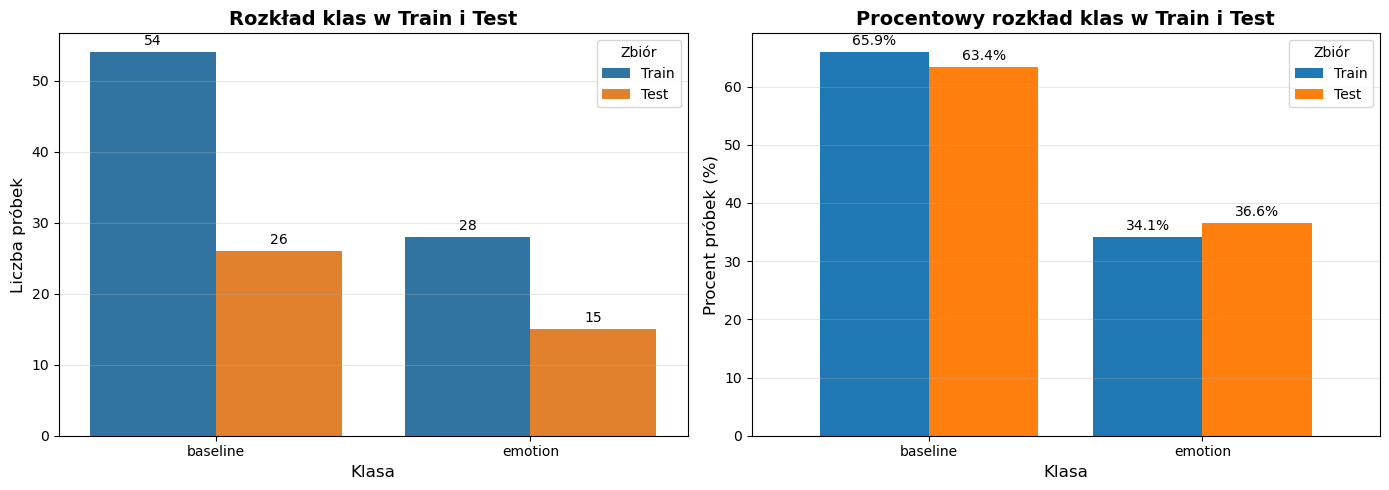


📊 LICZBA PRÓBEK PER KLASĘ:
--------------------------------------------------------------------------------
TRAIN:
   baseline    :   54 próbek
   emotion     :   28 próbek

TEST:
   baseline    :   26 próbek
   emotion     :   15 próbek


In [ ]:
# ============================================================================
# KROK 7: WIZUALIZACJA I ANALIZA DANYCH
# ============================================================================

print("=" * 80)
print("KROK 7: WIZUALIZACJA I ANALIZA DANYCH")
print("=" * 80)

# Sprawdź dostępność zmiennych
if 'X_train' not in globals() or 'y_train' not in globals() or 'X_test' not in globals() or 'y_test' not in globals():
    print("\n❌❌❌ BŁĄD: Najpierw uruchom KROK 5 i KROK 6!")
    raise NameError("X_train, y_train, X_test, y_test nie są zdefiniowane")

if 'X_train_bal' not in globals() or 'y_train_bal' not in globals():
    print("\n❌❌❌ BŁĄD: Najpierw uruchom KROK 6 (SMOTE)!")
    raise NameError("X_train_bal, y_train_bal nie są zdefiniowane")

# 1️⃣ SPRAWDZENIE ROZKŁADU KLAS PO PODZIALE
print(f"\n{'='*80}")
print("1️⃣ SPRAWDZENIE ROZKŁADU KLAS PO PODZIALE")
print(f"{'='*80}")

# Przygotuj dane do wizualizacji
train_labels_df = pd.DataFrame({
    'label': label_encoder.inverse_transform(y_train),
    'set': 'Train'
})
test_labels_df = pd.DataFrame({
    'label': label_encoder.inverse_transform(y_test),
    'set': 'Test'
})
labels_df = pd.concat([train_labels_df, test_labels_df], ignore_index=True)

# Wykres słupkowy liczby próbek w train i test dla każdej klasy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wykres 1: Porównanie train vs test
sns.countplot(data=labels_df, x='label', hue='set', ax=axes[0])
axes[0].set_title('Rozkład klas w Train i Test', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Klasa', fontsize=12)
axes[0].set_ylabel('Liczba próbek', fontsize=12)
axes[0].legend(title='Zbiór')
axes[0].grid(True, alpha=0.3, axis='y')
# Dodaj wartości na słupkach
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', rotation=0, padding=3)

# Wykres 2: Procentowy rozkład
train_pct = pd.Series(label_encoder.inverse_transform(y_train)).value_counts(normalize=True) * 100
test_pct = pd.Series(label_encoder.inverse_transform(y_test)).value_counts(normalize=True) * 100
comparison_df = pd.DataFrame({
    'Train': train_pct,
    'Test': test_pct
}).fillna(0)
comparison_df.plot(kind='bar', ax=axes[1], rot=0, width=0.8)
axes[1].set_title('Procentowy rozkład klas w Train i Test', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Klasa', fontsize=12)
axes[1].set_ylabel('Procent próbek (%)', fontsize=12)
axes[1].legend(title='Zbiór')
axes[1].grid(True, alpha=0.3, axis='y')
# Dodaj wartości na słupkach
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f%%', rotation=0, padding=3)

plt.tight_layout()
plt.show()

# Wyświetl liczby próbek
print(f"\n📊 LICZBA PRÓBEK PER KLASĘ:")
print("-" * 80)
print("TRAIN:")
train_counts = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
for label in train_counts.index:
    print(f"   {label:12s}: {train_counts[label]:4d} próbek")
print("\nTEST:")
test_counts = pd.Series(label_encoder.inverse_transform(y_test)).value_counts()
for label in test_counts.index:
    print(f"   {label:12s}: {test_counts[label]:4d} próbek")


In [ ]:
# 2️⃣ STATYSTYKI OPISOWE
print(f"\n{'='*80}")
print("2️⃣ STATYSTYKI OPISOWE")
print(f"{'='*80}")

# Balance ratio przed SMOTE
train_counts = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
if len(train_counts) >= 2:
    balance_ratio_before = min(train_counts.values) / max(train_counts.values)
    print(f"\n📊 BALANCE RATIO (przed SMOTE):")
    print(f"   Balance ratio = min / max = {min(train_counts.values)} / {max(train_counts.values)} = {balance_ratio_before:.4f}")
    print(f"   Klasa większościowa: {train_counts.idxmax()} ({max(train_counts.values)} próbek)")
    print(f"   Klasa mniejszościowa: {train_counts.idxmin()} ({min(train_counts.values)} próbek)")

# Balance ratio po SMOTE
if 'y_train_bal' in globals():
    train_bal_counts = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
    if len(train_bal_counts) >= 2:
        balance_ratio_after = min(train_bal_counts.values) / max(train_bal_counts.values)
        print(f"\n📊 BALANCE RATIO (po SMOTE):")
        print(f"   Balance ratio = min / max = {min(train_bal_counts.values)} / {max(train_bal_counts.values)} = {balance_ratio_after:.4f}")
        print(f"   Klasa większościowa: {train_bal_counts.idxmax()} ({max(train_bal_counts.values)} próbek)")
        print(f"   Klasa mniejszościowa: {train_bal_counts.idxmin()} ({min(train_bal_counts.values)} próbek)")

# Statystyki opisowe cech
print(f"\n📊 STATYSTYKI OPISOWE CECH:")
print("-" * 80)
print(f"   Train shape: {X_train.shape}")
print(f"   Test shape: {X_test.shape}")
if 'X_train_bal' in globals():
    print(f"   Train (po SMOTE) shape: {X_train_bal.shape}")

# Wybierz kilka przykładowych cech do wyświetlenia statystyk
if isinstance(X_train, pd.DataFrame):
    feature_cols = X_train.columns.tolist()
    n_features_to_show = min(10, len(feature_cols))
    sample_features = feature_cols[:n_features_to_show]
    
    print(f"\n📊 STATYSTYKI DLA PRZYKŁADOWYCH CECH (pierwsze {n_features_to_show}):")
    print("-" * 80)
    stats_df = X_train[sample_features].describe().T
    print(stats_df)
else:
    print(f"\n📊 STATYSTYKI DLA WSZYSTKICH CECH:")
    print("-" * 80)
    print(f"   Średnia: {np.mean(X_train, axis=0)[:5]}...")
    print(f"   Odchylenie std: {np.std(X_train, axis=0)[:5]}...")
    print(f"   Min: {np.min(X_train, axis=0)[:5]}...")
    print(f"   Max: {np.max(X_train, axis=0)[:5]}...")



2️⃣ STATYSTYKI OPISOWE

📊 BALANCE RATIO (przed SMOTE):
   Balance ratio = min / max = 28 / 54 = 0.5185
   Klasa większościowa: baseline (54 próbek)
   Klasa mniejszościowa: emotion (28 próbek)

📊 BALANCE RATIO (po SMOTE):
   Balance ratio = min / max = 54 / 54 = 1.0000
   Klasa większościowa: baseline (54 próbek)
   Klasa mniejszościowa: baseline (54 próbek)

📊 STATYSTYKI OPISOWE CECH:
--------------------------------------------------------------------------------
   Train shape: (82, 60)
   Test shape: (41, 60)
   Train (po SMOTE) shape: (108, 60)

📊 STATYSTYKI DLA PRZYKŁADOWYCH CECH (pierwsze 10):
--------------------------------------------------------------------------------
                count      mean       std       min       25%       50%  \
acc_x_mean       82.0  0.048685  0.946139 -1.458405 -0.640204 -0.048435   
acc_x_std        82.0 -0.167155  0.988893 -0.794712 -0.756888 -0.696232   
acc_x_min        82.0  0.191348  0.974458 -2.377571 -0.695230  0.399755   
acc_x_max 

In [ ]:
# 3️⃣ WIZUALIZACJA CECH
print(f"\n{'='*80}")
print("3️⃣ WIZUALIZACJA CECH")
print(f"{'='*80}")

# Wybierz kilka cech do wizualizacji
if isinstance(X_train, pd.DataFrame):
    feature_cols = X_train.columns.tolist()
    n_features_to_plot = min(6, len(feature_cols))
    features_to_plot = feature_cols[:n_features_to_plot]
    
    # Histogramy dla wybranych cech
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, feature in enumerate(features_to_plot):
        if idx < len(axes):
            X_train[feature].hist(bins=50, ax=axes[idx], alpha=0.7, label='Train')
            if isinstance(X_test, pd.DataFrame):
                X_test[feature].hist(bins=50, ax=axes[idx], alpha=0.7, label='Test')
            axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Wartość', fontsize=10)
            axes[idx].set_ylabel('Częstość', fontsize=10)
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)
    
    # Ukryj puste subploty
    for idx in range(len(features_to_plot), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Histogramy wybranych cech (Train vs Test)', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Boxploty dla wybranych cech
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, feature in enumerate(features_to_plot):
        if idx < len(axes):
            data_to_plot = [X_train[feature].dropna(), X_test[feature].dropna() if isinstance(X_test, pd.DataFrame) else X_test[:, feature_cols.index(feature)]]
            axes[idx].boxplot(data_to_plot, labels=['Train', 'Test'])
            axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')
            axes[idx].set_ylabel('Wartość', fontsize=10)
            axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Ukryj puste subploty
    for idx in range(len(features_to_plot), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Boxploty wybranych cech (Train vs Test)', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Heatmapa korelacji (tylko dla pierwszych 20 cech, żeby nie było za dużo)
    n_features_corr = min(20, len(feature_cols))
    features_for_corr = feature_cols[:n_features_corr]
    
    print(f"\n📊 HEATMAPA KORELACJI (pierwsze {n_features_corr} cech):")
    print("-" * 80)
    
    corr_matrix = X_train[features_for_corr].corr()
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title(f'Macierz korelacji cech (Train, pierwsze {n_features_corr} cech)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print(f"   ✅ Wizualizacja cech zakończona")
else:
    print(f"   ⚠️ X_train nie jest DataFrame - pomijam szczegółowe wizualizacje cech")



3️⃣ WIZUALIZACJA CECH


NameError: name 'X_train' is not defined

In [ ]:
# 4️⃣ WIZUALIZACJA BALANSU PO SMOTE
print(f"\n{'='*80}")
print("4️⃣ WIZUALIZACJA BALANSU PO SMOTE")
print(f"{'='*80}")

# Porównanie liczby próbek w train przed i po SMOTE
train_before_counts = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
train_after_counts = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()

# Przygotuj dane do wizualizacji
comparison_data = []
for label in train_before_counts.index:
    comparison_data.append({
        'Klasa': label,
        'Przed SMOTE': train_before_counts[label],
        'Po SMOTE': train_after_counts.get(label, 0)
    })
comparison_df = pd.DataFrame(comparison_data)

# Funkcja konwertująca kolumny na int
def convert_to_int(df):
    df_copy = df.copy()
    for col in df_copy.columns:
        if col != 'Klasa':  # Pomijamy kolumnę 'Klasa' (nie numeryczna)
            # Najpierw konwertujemy na liczby (float), co rozwiązuje problem stringów
            df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')
            # Zamieniamy NaN na 0
            df_copy[col] = df_copy[col].fillna(0)
            # Zaokrąglamy do najbliższej liczby całkowitej i zmieniamy typ na int
            df_copy[col] = df_copy[col].round(0).astype(int)
    return df_copy

# Zastosowanie funkcji do DataFrame
comparison_df = convert_to_int(comparison_df)

# Sprawdzenie wyników
print(f"\n📊 TYPY DANYCH W comparison_df:")
print(comparison_df.dtypes)
print(f"\n📊 PIERWSZE WIERSZE comparison_df:")
print(comparison_df.head())

# Wykres słupkowy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wykres 1: Liczby bezwzględne
x = np.arange(len(comparison_df))
width = 0.35
axes[0].bar(x - width/2, comparison_df['Przed SMOTE'], width, label='Przed SMOTE', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Po SMOTE'], width, label='Po SMOTE', alpha=0.8)
axes[0].set_xlabel('Klasa', fontsize=12)
axes[0].set_ylabel('Liczba próbek', fontsize=12)
axes[0].set_title('Liczba próbek przed i po SMOTE', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Klasa'])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Dodaj wartości na słupkach (naprawione obliczanie maksimum)
max_value = max(comparison_df['Przed SMOTE'].max(), comparison_df['Po SMOTE'].max())
for i, row in comparison_df.iterrows():
    przed_val = int(row['Przed SMOTE'])
    po_val = int(row['Po SMOTE'])
    axes[0].text(i - width/2, przed_val + max_value * 0.01, 
                 f"{przed_val}", ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, po_val + max_value * 0.01, 
                 f"{po_val}", ha='center', va='bottom', fontsize=9)

# Wykres 2: Procenty
train_before_pct = train_before_counts / len(y_train) * 100
train_after_pct = train_after_counts / len(y_train_bal) * 100
pct_comparison_df = pd.DataFrame({
    'Przed SMOTE': train_before_pct,
    'Po SMOTE': train_after_pct
}).fillna(0)
pct_comparison_df.plot(kind='bar', ax=axes[1], rot=0, width=0.8)
axes[1].set_xlabel('Klasa', fontsize=12)
axes[1].set_ylabel('Procent próbek (%)', fontsize=12)
axes[1].set_title('Procentowy rozkład klas przed i po SMOTE', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
# Dodaj wartości na słupkach
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f%%', rotation=0, padding=3)

plt.tight_layout()
plt.show()

# Wyświetl szczegóły
print(f"\n📊 SZCZEGÓŁOWE PORÓWNANIE:")
print("-" * 80)
print("PRZED SMOTE:")
for label in train_before_counts.index:
    count = train_before_counts[label]
    pct = (count / len(y_train) * 100) if len(y_train) > 0 else 0
    print(f"   {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
print(f"\nPO SMOTE:")
for label in train_after_counts.index:
    count = train_after_counts[label]
    pct = (count / len(y_train_bal) * 100) if len(y_train_bal) > 0 else 0
    print(f"   {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
print(f"\n   Train przed SMOTE: {len(y_train)} próbek")
print(f"   Train po SMOTE: {len(y_train_bal)} próbek")
print(f"   Dodano: {len(y_train_bal) - len(y_train)} syntetycznych próbek")



4️⃣ WIZUALIZACJA BALANSU PO SMOTE


NameError: name 'pd' is not defined

In [ ]:
# 5️⃣ ANALIZA PER SUBJECT
print(f"\n{'='*80}")
print("5️⃣ ANALIZA PER SUBJECT")
print(f"{'='*80}")

# Sprawdź rozkład klas per subject w train i test
if 'groups_train' in globals() and 'groups_test' in globals():
    # Przygotuj dane per subject
    train_subjects_list = groups_train if isinstance(groups_train, list) else list(groups_train)
    test_subjects_list = groups_test if isinstance(groups_test, list) else list(groups_test)
    
    # Train per subject
    train_subject_df = pd.DataFrame({
        'subject': train_subjects_list,
        'label': label_encoder.inverse_transform(y_train)
    })
    
    # Test per subject
    test_subject_df = pd.DataFrame({
        'subject': test_subjects_list,
        'label': label_encoder.inverse_transform(y_test)
    })
    
    # Wykres per subject
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Train per subject
    train_subject_counts = train_subject_df.groupby(['subject', 'label']).size().unstack(fill_value=0)
    train_subject_counts.plot(kind='bar', ax=axes[0], rot=0, width=0.8)
    axes[0].set_title('Rozkład klas per subject - TRAIN', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Subject', fontsize=12)
    axes[0].set_ylabel('Liczba próbek', fontsize=12)
    axes[0].legend(title='Klasa', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Test per subject
    test_subject_counts = test_subject_df.groupby(['subject', 'label']).size().unstack(fill_value=0)
    test_subject_counts.plot(kind='bar', ax=axes[1], rot=0, width=0.8)
    axes[1].set_title('Rozkład klas per subject - TEST', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Subject', fontsize=12)
    axes[1].set_ylabel('Liczba próbek', fontsize=12)
    axes[1].legend(title='Klasa', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Wyświetl szczegóły per subject
    print(f"\n📊 ROZKŁAD KLAS PER SUBJECT:")
    print("-" * 80)
    print("TRAIN:")
    for subject in sorted(train_subject_df['subject'].unique()):
        subject_data = train_subject_df[train_subject_df['subject'] == subject]
        label_dist = subject_data['label'].value_counts()
        print(f"\n  {subject}:")
        for label in label_dist.index:
            print(f"    {label:12s}: {label_dist[label]:4d} próbek")
    
    print(f"\nTEST:")
    for subject in sorted(test_subject_df['subject'].unique()):
        subject_data = test_subject_df[test_subject_df['subject'] == subject]
        label_dist = subject_data['label'].value_counts()
        print(f"\n  {subject}:")
        for label in label_dist.index:
            print(f"    {label:12s}: {label_dist[label]:4d} próbek")
else:
    print(f"   ⚠️ groups_train lub groups_test nie są dostępne - pomijam analizę per subject")



5️⃣ ANALIZA PER SUBJECT
   ⚠️ groups_train lub groups_test nie są dostępne - pomijam analizę per subject


## KROK 8: TRENOWANIE MODELI ML

Trenujemy modele: Logistic Regression, Random Forest, XGBoost, SVM.


In [ ]:
# ============================================================================
# KROK 8: TRENOWANIE MODELI ML
# ============================================================================

print("=" * 80)
print("KROK 8: TRENOWANIE MODELI ML")
print("=" * 80)

# Sprawdź dostępność zmiennych
if 'X_train_bal' not in globals() or 'y_train_bal' not in globals():
    print("\n❌❌❌ BŁĄD: Najpierw uruchom KROK 6 (SMOTE)!")
    raise NameError("X_train_bal, y_train_bal nie są zdefiniowane")

# Konwertuj na numpy array jeśli potrzeba
if isinstance(X_train_bal, pd.DataFrame):
    X_train_bal_array = X_train_bal.values
    X_test_array = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
else:
    X_train_bal_array = X_train_bal
    X_test_array = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

print(f"\n📊 PRZYGOTOWANIE DANYCH:")
print(f"   X_train_bal shape: {X_train_bal_array.shape}")
print(f"   y_train_bal shape: {y_train_bal.shape}")
print(f"   X_test shape: {X_test_array.shape}")
print(f"   y_test shape: {y_test.shape}")

# Słownik do przechowywania wyników modeli
results = {}

# 1. Logistic Regression
print(f"\n{'='*80}")
print("1. LOGISTIC REGRESSION")
print(f"{'='*80}")
try:
    lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, n_jobs=-1)
    print("   🔧 Trenuję model...")
    lr.fit(X_train_bal_array, y_train_bal)
    y_pred_lr = lr.predict(X_test_array)
    
    acc_lr = accuracy_score(y_test, y_pred_lr)
    bal_acc_lr = balanced_accuracy_score(y_test, y_pred_lr)
    macro_f1_lr = f1_score(y_test, y_pred_lr, average='macro')
    cm_lr = confusion_matrix(y_test, y_pred_lr)
    
    results['LogisticRegression'] = {
        'model': lr,
        'y_pred': y_pred_lr,
        'accuracy': acc_lr,
        'balanced_accuracy': bal_acc_lr,
        'macro_f1': macro_f1_lr,
        'confusion_matrix': cm_lr,
        'classification_report': classification_report(y_test, y_pred_lr, 
                                                         target_names=label_encoder.classes_, 
                                                         output_dict=True)
    }
    
    print(f"   ✅ Trenowanie zakończone!")
    print(f"      Accuracy: {acc_lr:.4f}")
    print(f"      Balanced Accuracy: {bal_acc_lr:.4f}")
    print(f"      Macro F1: {macro_f1_lr:.4f}")
except Exception as e:
    print(f"   ❌ Błąd: {e}")

# 2. Random Forest
print(f"\n{'='*80}")
print("2. RANDOM FOREST")
print(f"{'='*80}")
try:
    rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, 
                                random_state=42, n_jobs=-1, max_depth=10)
    print("   🔧 Trenuję model...")
    rf.fit(X_train_bal_array, y_train_bal)
    y_pred_rf = rf.predict(X_test_array)
    
    acc_rf = accuracy_score(y_test, y_pred_rf)
    bal_acc_rf = balanced_accuracy_score(y_test, y_pred_rf)
    macro_f1_rf = f1_score(y_test, y_pred_rf, average='macro')
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    
    results['RandomForest'] = {
        'model': rf,
        'y_pred': y_pred_rf,
        'accuracy': acc_rf,
        'balanced_accuracy': bal_acc_rf,
        'macro_f1': macro_f1_rf,
        'confusion_matrix': cm_rf,
        'classification_report': classification_report(y_test, y_pred_rf, 
                                                       target_names=label_encoder.classes_, 
                                                       output_dict=True)
    }
    
    print(f"   ✅ Trenowanie zakończone!")
    print(f"      Accuracy: {acc_rf:.4f}")
    print(f"      Balanced Accuracy: {bal_acc_rf:.4f}")
    print(f"      Macro F1: {macro_f1_rf:.4f}")
except Exception as e:
    print(f"   ❌ Błąd: {e}")

# 3. XGBoost
print(f"\n{'='*80}")
print("3. XGBOOST")
print(f"{'='*80}")
if XGBOOST_AVAILABLE:
    try:
        xgb = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss')
        print("   🔧 Trenuję model...")
        xgb.fit(X_train_bal_array, y_train_bal)
        y_pred_xgb = xgb.predict(X_test_array)
        
        acc_xgb = accuracy_score(y_test, y_pred_xgb)
        bal_acc_xgb = balanced_accuracy_score(y_test, y_pred_xgb)
        macro_f1_xgb = f1_score(y_test, y_pred_xgb, average='macro')
        cm_xgb = confusion_matrix(y_test, y_pred_xgb)
        
        results['XGBoost'] = {
            'model': xgb,
            'y_pred': y_pred_xgb,
            'accuracy': acc_xgb,
            'balanced_accuracy': bal_acc_xgb,
            'macro_f1': macro_f1_xgb,
            'confusion_matrix': cm_xgb,
            'classification_report': classification_report(y_test, y_pred_xgb, 
                                                           target_names=label_encoder.classes_, 
                                                           output_dict=True)
        }
        
        print(f"   ✅ Trenowanie zakończone!")
        print(f"      Accuracy: {acc_xgb:.4f}")
        print(f"      Balanced Accuracy: {bal_acc_xgb:.4f}")
        print(f"      Macro F1: {macro_f1_xgb:.4f}")
    except Exception as e:
        print(f"   ❌ Błąd: {e}")
else:
    print(f"   ⚠️ XGBoost niedostępny - pomijam")

# 4. SVM
print(f"\n{'='*80}")
print("4. SVM")
print(f"{'='*80}")
try:
    svm = SVC(class_weight='balanced', random_state=42, probability=True)
    print("   🔧 Trenuję model...")
    svm.fit(X_train_bal_array, y_train_bal)
    y_pred_svm = svm.predict(X_test_array)
    
    acc_svm = accuracy_score(y_test, y_pred_svm)
    bal_acc_svm = balanced_accuracy_score(y_test, y_pred_svm)
    macro_f1_svm = f1_score(y_test, y_pred_svm, average='macro')
    cm_svm = confusion_matrix(y_test, y_pred_svm)
    
    results['SVM'] = {
        'model': svm,
        'y_pred': y_pred_svm,
        'accuracy': acc_svm,
        'balanced_accuracy': bal_acc_svm,
        'macro_f1': macro_f1_svm,
        'confusion_matrix': cm_svm,
        'classification_report': classification_report(y_test, y_pred_svm, 
                                                        target_names=label_encoder.classes_, 
                                                        output_dict=True)
    }
    
    print(f"   ✅ Trenowanie zakończone!")
    print(f"      Accuracy: {acc_svm:.4f}")
    print(f"      Balanced Accuracy: {bal_acc_svm:.4f}")
    print(f"      Macro F1: {macro_f1_svm:.4f}")
except Exception as e:
    print(f"   ❌ Błąd: {e}")

# 5. Ensemble Voting Classifier
print(f"\n{'='*80}")
print("5. ENSEMBLE VOTING CLASSIFIER")
print(f"{'='*80}")

try:
    from sklearn.ensemble import VotingClassifier
    from sklearn.neighbors import KNeighborsClassifier
    
    # Tworzymy pojedyncze modele
    logreg_ensemble = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    rf_ensemble = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
    knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    
    # Łączymy je w VotingClassifier (soft voting - używamy prawdopodobieństw)
    ensemble = VotingClassifier(
        estimators=[('logreg', logreg_ensemble), ('rf', rf_ensemble), ('knn', knn)],
        voting='soft'  # soft - średnie prawdopodobieństwa, hard - głosowanie większościowe
    )
    
    print("   🔧 Trenuję ensemble model...")
    print("      Składniki: LogisticRegression + RandomForest + KNeighborsClassifier")
    print("      Voting: soft (średnie prawdopodobieństwa)")
    ensemble.fit(X_train_bal_array, y_train_bal)
    y_pred_ensemble = ensemble.predict(X_test_array)
    
    acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
    bal_acc_ensemble = balanced_accuracy_score(y_test, y_pred_ensemble)
    macro_f1_ensemble = f1_score(y_test, y_pred_ensemble, average='macro')
    cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
    
    results['Ensemble'] = {
        'model': ensemble,
        'y_pred': y_pred_ensemble,
        'accuracy': acc_ensemble,
        'balanced_accuracy': bal_acc_ensemble,
        'macro_f1': macro_f1_ensemble,
        'confusion_matrix': cm_ensemble,
        'classification_report': classification_report(y_test, y_pred_ensemble, 
                                                        target_names=label_encoder.classes_, 
                                                        output_dict=True)
    }
    
    print(f"   ✅ Trenowanie zakończone!")
    print(f"      Accuracy: {acc_ensemble:.4f}")
    print(f"      Balanced Accuracy: {bal_acc_ensemble:.4f}")
    print(f"      Macro F1: {macro_f1_ensemble:.4f}")
except Exception as e:
    print(f"   ❌ Błąd: {e}")
    import traceback
    traceback.print_exc()

# 6. LSTM (Time Series Model)
print(f"\n{'='*80}")
print("6. LSTM (TIME SERIES MODEL)")
print(f"{'='*80}")

if TENSORFLOW_AVAILABLE:
    try:
        # Przygotowanie danych dla LSTM
        # LSTM wymaga danych w formacie (samples, timesteps, features)
        # Ponieważ mamy już statystyczne cechy z okien, traktujemy każdą próbkę jako sekwencję długości 1
        # Reshape: (samples, features) -> (samples, 1, features)
        X_train_lstm = X_train_bal_array.reshape(X_train_bal_array.shape[0], 1, X_train_bal_array.shape[1])
        X_test_lstm = X_test_array.reshape(X_test_array.shape[0], 1, X_test_array.shape[1])
        
        # Konwersja etykiet do kategorii (one-hot encoding dla LSTM)
        n_classes = len(np.unique(y_train_bal))
        y_train_lstm = to_categorical(y_train_bal, num_classes=n_classes)
        y_test_lstm = to_categorical(y_test, num_classes=n_classes)
        
        print(f"   📊 Przygotowanie danych dla LSTM:")
        print(f"      X_train_lstm shape: {X_train_lstm.shape} (samples, timesteps=1, features)")
        print(f"      X_test_lstm shape: {X_test_lstm.shape}")
        print(f"      y_train_lstm shape: {y_train_lstm.shape} (one-hot encoded)")
        print(f"      y_test_lstm shape: {y_test_lstm.shape}")
        
        # Budowa modelu LSTM
        print(f"   🔧 Buduję model LSTM...")
        lstm_model = Sequential([
            LSTM(64, activation='relu', input_shape=(1, X_train_bal_array.shape[1]), return_sequences=True),
            Dropout(0.3),
            LSTM(32, activation='relu', return_sequences=False),
            Dropout(0.3),
            BatchNormalization(),
            Dense(16, activation='relu'),
            Dropout(0.2),
            Dense(n_classes, activation='softmax')
        ])
        
        # Kompilacja modelu
        lstm_model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        print(f"   📋 Architektura modelu:")
        lstm_model.summary()
        
        # Callback dla early stopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=0
        )
        
        # Trenowanie modelu
        print(f"   🔧 Trenuję model LSTM...")
        print(f"      Epochs: 50, Batch size: 16, Validation split: 0.2")
        
        history = lstm_model.fit(
            X_train_lstm, y_train_lstm,
            epochs=50,
            batch_size=16,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=0  # Wyłącz szczegółowe logi podczas treningu
        )
        
        # Predykcja
        y_pred_proba_lstm = lstm_model.predict(X_test_lstm, verbose=0)
        y_pred_lstm = np.argmax(y_pred_proba_lstm, axis=1)
        
        # Oblicz metryki
        acc_lstm = accuracy_score(y_test, y_pred_lstm)
        bal_acc_lstm = balanced_accuracy_score(y_test, y_pred_lstm)
        macro_f1_lstm = f1_score(y_test, y_pred_lstm, average='macro')
        cm_lstm = confusion_matrix(y_test, y_pred_lstm)
        
        results['LSTM'] = {
            'model': lstm_model,
            'y_pred': y_pred_lstm,
            'accuracy': acc_lstm,
            'balanced_accuracy': bal_acc_lstm,
            'macro_f1': macro_f1_lstm,
            'confusion_matrix': cm_lstm,
            'classification_report': classification_report(y_test, y_pred_lstm, 
                                                           target_names=label_encoder.classes_, 
                                                           output_dict=True),
            'history': history.history  # Historia treningu dla wizualizacji
        }
        
        print(f"   ✅ Trenowanie zakończone!")
        print(f"      Accuracy: {acc_lstm:.4f}")
        print(f"      Balanced Accuracy: {bal_acc_lstm:.4f}")
        print(f"      Macro F1: {macro_f1_lstm:.4f}")
        print(f"      Liczba epok: {len(history.history['loss'])}")
        
        # Wizualizacja historii treningu
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Loss
        axes[0].plot(history.history['loss'], label='Train Loss', marker='o')
        axes[0].plot(history.history['val_loss'], label='Validation Loss', marker='s')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('LSTM Training History - Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Accuracy
        axes[1].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
        axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('LSTM Training History - Accuracy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"   ❌ Błąd podczas trenowania LSTM: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f"   ⚠️ TensorFlow/Keras niedostępny - pomijam LSTM")
    print(f"   💡 Zainstaluj: pip install tensorflow")

print(f"\n✅ Trenowanie wszystkich modeli zakończone!")
print(f"   Wytrenowano {len(results)} modeli")

# ============================================================================
# WYBÓR TOP 10 NAJWAŻNIEJSZYCH CECH (dla Streamlit app)
# ============================================================================

print(f"\n{'='*80}")
print("WYBÓR TOP 10 NAJWAŻNIEJSZYCH CECH")
print(f"{'='*80}")

# Pobierz feature importance z RandomForest lub XGBoost
top_10_features = None
feature_importance_dict = None

# Spróbuj z RandomForest
if 'RandomForest' in results:
    try:
        rf_model = results['RandomForest']['model']
        if hasattr(rf_model, 'feature_importances_'):
            feature_importance = rf_model.feature_importances_
            feature_names_list = X_train.columns.tolist() if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
            
            # Stwórz DataFrame z importance
            importance_df = pd.DataFrame({
                'feature': feature_names_list,
                'importance': feature_importance
            }).sort_values('importance', ascending=False)
            
            # Wybierz top 10
            top_10_features = importance_df.head(10)['feature'].tolist()
            feature_importance_dict = dict(zip(importance_df['feature'], importance_df['importance']))
            
            print(f"\n✅ Użyto RandomForest do wyboru top 10 cech")
            print(f"\n📊 TOP 10 NAJWAŻNIEJSZYCH CECH:")
            print("-" * 80)
            for i, feat in enumerate(top_10_features, 1):
                importance_val = feature_importance_dict[feat]
                print(f"   {i:2d}. {feat:30s}: {importance_val:.6f}")
    except Exception as e:
        print(f"   ⚠️ Błąd przy RandomForest: {e}")

# Jeśli RandomForest nie zadziałał, spróbuj z XGBoost
if top_10_features is None and 'XGBoost' in results:
    try:
        xgb_model = results['XGBoost']['model']
        if hasattr(xgb_model, 'feature_importances_'):
            feature_importance = xgb_model.feature_importances_
            feature_names_list = X_train.columns.tolist() if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
            
            # Stwórz DataFrame z importance
            importance_df = pd.DataFrame({
                'feature': feature_names_list,
                'importance': feature_importance
            }).sort_values('importance', ascending=False)
            
            # Wybierz top 10
            top_10_features = importance_df.head(10)['feature'].tolist()
            feature_importance_dict = dict(zip(importance_df['feature'], importance_df['importance']))
            
            print(f"\n✅ Użyto XGBoost do wyboru top 10 cech")
            print(f"\n📊 TOP 10 NAJWAŻNIEJSZYCH CECH:")
            print("-" * 80)
            for i, feat in enumerate(top_10_features, 1):
                importance_val = feature_importance_dict[feat]
                print(f"   {i:2d}. {feat:30s}: {importance_val:.6f}")
    except Exception as e:
        print(f"   ⚠️ Błąd przy XGBoost: {e}")

# Jeśli żaden model nie zadziałał, użyj pierwszych 10 cech
if top_10_features is None:
    feature_names_list = X_train.columns.tolist() if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
    top_10_features = feature_names_list[:10]
    print(f"\n⚠️ Nie można pobrać feature importance - używam pierwszych 10 cech")
    print(f"   Top 10 cech: {top_10_features}")

# Zapisz top 10 cech do zmiennej globalnej
globals()['top_10_features'] = top_10_features
globals()['feature_importance_dict'] = feature_importance_dict

print(f"\n✅ Top 10 cech wybrane i zapisane!")


KROK 8: TRENOWANIE MODELI ML

❌❌❌ BŁĄD: Najpierw uruchom KROK 6 (SMOTE)!


NameError: X_train_bal, y_train_bal nie są zdefiniowane

## KROK 9: EWALUACJA MODELI

Porównujemy wyniki wszystkich modeli: Accuracy, Balanced Accuracy, Macro F1, Confusion Matrices.


In [ ]:
# ============================================================================
# KROK 9: EWALUACJA MODELI
# ============================================================================

print("=" * 80)
print("KROK 9: EWALUACJA MODELI")
print("=" * 80)

if 'results' not in globals() or len(results) == 0:
    print("\n❌❌❌ BŁĄD: Najpierw uruchom KROK 8 (trenowanie modeli)!")
    raise NameError("results nie są zdefiniowane")

# 1. Porównanie metryk globalnych
print(f"\n{'='*80}")
print("1. PORÓWNANIE METRYK GLOBALNYCH")
print(f"{'='*80}")

metrics_summary = []
for model_name, result in results.items():
    metrics_summary.append({
        'Model': model_name,
        'Accuracy': result['accuracy'],
        'Balanced Accuracy': result['balanced_accuracy'],
        'Macro F1': result['macro_f1']
    })

metrics_df = pd.DataFrame(metrics_summary)
print(f"\n📊 METRYKI WSZYSTKICH MODELI:")
print("-" * 80)
print(metrics_df.to_string(index=False))

# Tabela z porównaniem modeli (z zaokrągleniem do 4 miejsc po przecinku)
metrics_df_rounded = metrics_df.round(4)
metrics_df_rounded = metrics_df_rounded.set_index('Model')
print(f"\n📊 TABELA PORÓWNAWCZA MODELI (zaokrąglone do 4 miejsc):")
print("-" * 80)
display(metrics_df_rounded)

# Wizualizacja metryk - wykres słupkowy (pionowy)
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics_df))
width = 0.25
ax.bar(x - width, metrics_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x, metrics_df['Balanced Accuracy'], width, label='Balanced Accuracy', alpha=0.8)
ax.bar(x + width, metrics_df['Macro F1'], width, label='Macro F1', alpha=0.8)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Porównanie metryk globalnych wszystkich modeli', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])
# Dodaj wartości na słupkach
for i, row in metrics_df.iterrows():
    ax.text(i - width, row['Accuracy'] + 0.01, f"{row['Accuracy']:.3f}", 
            ha='center', va='bottom', fontsize=8)
    ax.text(i, row['Balanced Accuracy'] + 0.01, f"{row['Balanced Accuracy']:.3f}", 
            ha='center', va='bottom', fontsize=8)
    ax.text(i + width, row['Macro F1'] + 0.01, f"{row['Macro F1']:.3f}", 
            ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# Wizualizacja metryk - wykres słupkowy (poziomy, jak w przykładzie użytkownika)
metrics_df_plot = metrics_df.set_index('Model')
metrics_df_plot.plot(kind="bar", figsize=(12, 6), rot=45)
plt.title("Porównanie modeli: Accuracy, Balanced Accuracy, Macro F1", fontsize=14, fontweight='bold')
plt.ylabel("Wartość metryki", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(title="Metryka", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
# Dodaj wartości na słupkach
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.3f', rotation=90, padding=3)
plt.tight_layout()
plt.show()

# 2. Confusion Matrices
print(f"\n{'='*80}")
print("2. CONFUSION MATRICES")
print(f"{'='*80}")

n_models = len(results)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
if n_models == 1:
    axes = [axes]

for idx, (model_name, result) in enumerate(results.items()):
    cm = result['confusion_matrix']
    # Normalizacja confusion matrix (procenty)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_,
                ax=axes[idx], cbar_kws={'label': 'Procent'})
    axes[idx].set_title(f'{model_name}\nConfusion Matrix (normalized)', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11)
    axes[idx].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()

# Wyświetl confusion matrices jako liczby
print(f"\n📊 CONFUSION MATRICES (liczby bezwzględne):")
print("-" * 80)
for model_name, result in results.items():
    print(f"\n{model_name}:")
    cm = result['confusion_matrix']
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    print(cm_df)


KROK 9: EWALUACJA MODELI

❌❌❌ BŁĄD: Najpierw uruchom KROK 8 (trenowanie modeli)!


NameError: results nie są zdefiniowane


3. PER-CLASS PRECISION I RECALL

📊 PRECISION PER CLASS:
--------------------------------------------------------------------------------
Model     Ensemble  LogisticRegression  RandomForest       SVM   XGBoost
Class                                                                   
baseline  0.882353            0.909091      0.709677  0.714286  0.705882
emotion   0.541667            0.684211      0.600000  0.538462  0.714286

📊 RECALL PER CLASS:
--------------------------------------------------------------------------------
Model     Ensemble  LogisticRegression  RandomForest       SVM   XGBoost
Class                                                                   
baseline  0.576923            0.769231      0.846154  0.769231  0.923077
emotion   0.866667            0.866667      0.400000  0.466667  0.333333


<Axes: xlabel='Class'>

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Per-Class Precision - wyższe = lepsze')

(0.0, 1.1)

[Text(0, 3, '0.882'), Text(0, 3, '0.542')]

[Text(0, 3, '0.909'), Text(0, 3, '0.684')]

[Text(0, 3, '0.710'), Text(0, 3, '0.600')]

[Text(0, 3, '0.714'), Text(0, 3, '0.538')]

[Text(0, 3, '0.706'), Text(0, 3, '0.714')]

<Axes: xlabel='Class'>

Text(0, 0.5, 'Recall (Sensitivity)')

Text(0.5, 1.0, 'Per-Class Recall (Sensitivity) - wyższe = lepsze')

(0.0, 1.1)

[Text(0, 3, '0.577'), Text(0, 3, '0.867')]

[Text(0, 3, '0.769'), Text(0, 3, '0.867')]

[Text(0, 3, '0.846'), Text(0, 3, '0.400')]

[Text(0, 3, '0.769'), Text(0, 3, '0.467')]

[Text(0, 3, '0.923'), Text(0, 3, '0.333')]

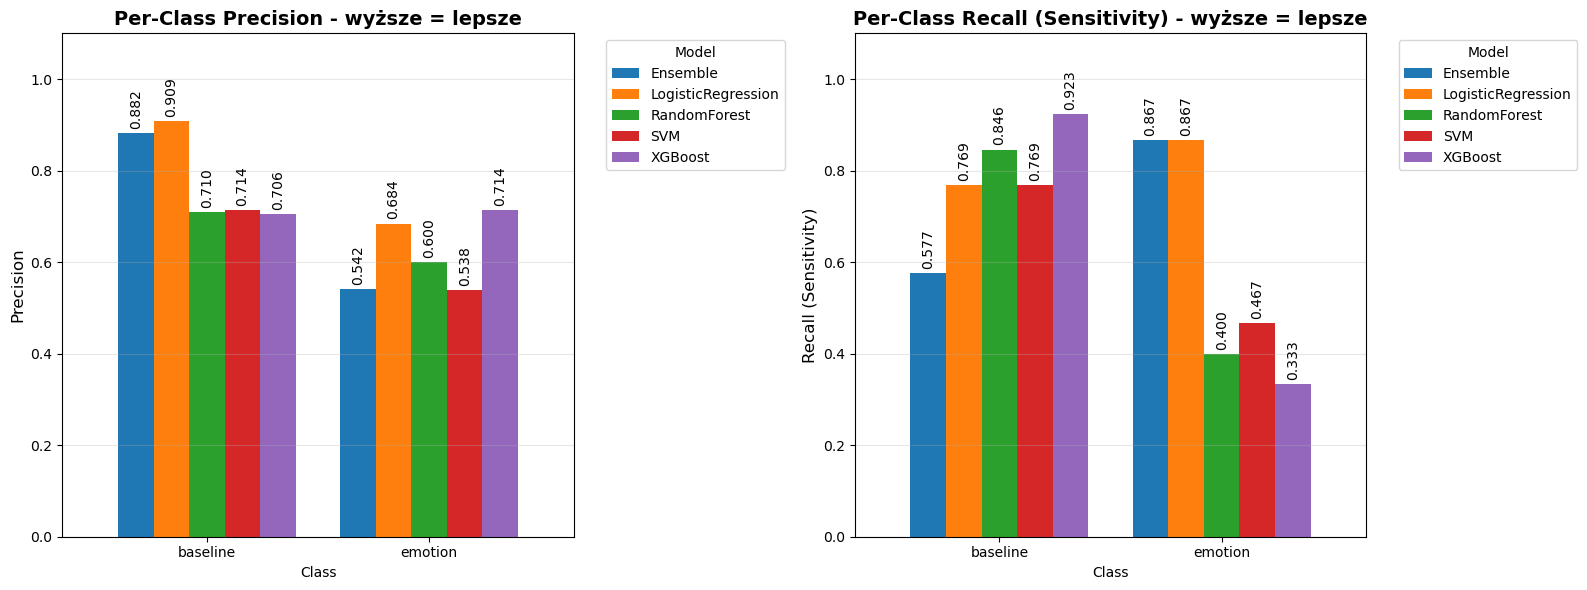


4. SZCZEGÓŁOWE RAPORTY KLASYFIKACJI

LogisticRegression:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    baseline       0.91      0.77      0.83        26
     emotion       0.68      0.87      0.76        15

    accuracy                           0.80        41
   macro avg       0.80      0.82      0.80        41
weighted avg       0.83      0.80      0.81        41


RandomForest:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    baseline       0.71      0.85      0.77        26
     emotion       0.60      0.40      0.48        15

    accuracy                           0.68        41
   macro avg       0.65      0.62      0.63        41
weighted avg       0.67      0.68      0.67        41


XGBoost:
--------------------------------------------------------------------------------
              precis

In [ ]:
# 3. Per-class Precision i Recall
print(f"\n{'='*80}")
print("3. PER-CLASS PRECISION I RECALL")
print(f"{'='*80}")

# Zbierz dane per-class
precision_data = []
recall_data = []

for model_name, result in results.items():
    report = result['classification_report']
    for label in label_encoder.classes_:
        if label in report:
            precision_data.append({
                'Model': model_name,
                'Class': label,
                'Precision': report[label]['precision']
            })
            recall_data.append({
                'Model': model_name,
                'Class': label,
                'Recall': report[label]['recall']
            })

precision_df = pd.DataFrame(precision_data)
recall_df = pd.DataFrame(recall_data)

precision_pivot = precision_df.pivot(index='Class', columns='Model', values='Precision')
recall_pivot = recall_df.pivot(index='Class', columns='Model', values='Recall')

print(f"\n📊 PRECISION PER CLASS:")
print("-" * 80)
print(precision_pivot.to_string())

print(f"\n📊 RECALL PER CLASS:")
print("-" * 80)
print(recall_pivot.to_string())

# Wizualizacja Precision i Recall
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

precision_pivot.plot(kind='bar', ax=axes[0], rot=0, width=0.8)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Per-Class Precision - wyższe = lepsze', fontsize=14, fontweight='bold')
axes[0].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.1])
# Dodaj wartości na słupkach
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.3f', rotation=90, padding=3)

recall_pivot.plot(kind='bar', ax=axes[1], rot=0, width=0.8)
axes[1].set_ylabel('Recall (Sensitivity)', fontsize=12)
axes[1].set_title('Per-Class Recall (Sensitivity) - wyższe = lepsze', fontsize=14, fontweight='bold')
axes[1].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 1.1])
# Dodaj wartości na słupkach
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.3f', rotation=90, padding=3)

plt.tight_layout()
plt.show()

# 4. Szczegółowe raporty klasyfikacji
print(f"\n{'='*80}")
print("4. SZCZEGÓŁOWE RAPORTY KLASYFIKACJI")
print(f"{'='*80}")

for model_name, result in results.items():
    print(f"\n{model_name}:")
    print("-" * 80)
    print(classification_report(y_test, result['y_pred'], 
                                 target_names=label_encoder.classes_))

# 5. Wybór najlepszego modelu
print(f"\n{'='*80}")
print("5. WYBÓR NAJLEPSZEGO MODELU")
print(f"{'='*80}")

# Znajdź najlepszy model według Balanced Accuracy
best_model_name = max(results.keys(), key=lambda k: results[k]['balanced_accuracy'])
best_result = results[best_model_name]

print(f"\n🏆 NAJLEPSZY MODEL (według Balanced Accuracy): {best_model_name}")
print(f"   Balanced Accuracy: {best_result['balanced_accuracy']:.4f}")
print(f"   Macro F1: {best_result['macro_f1']:.4f}")
print(f"   Accuracy: {best_result['accuracy']:.4f}")

print(f"\n✅ EWALUACJA ZAKOŃCZONA!")


## KROK 10: PRZYGOTOWANIE WYNIKÓW DLA STREAMLIT APP

Zbieramy wszystkie wyniki analizy w strukturze gotowej do użycia w aplikacji Streamlit.


In [ ]:
# ============================================================================
# KROK 10: PRZYGOTOWANIE WYNIKÓW DLA STREAMLIT APP
# ============================================================================

print("=" * 80)
print("KROK 10: PRZYGOTOWANIE WYNIKÓW DLA STREAMLIT APP")
print("=" * 80)

# Sprawdź dostępność zmiennych
if 'results' not in globals() or len(results) == 0:
    print("\n❌❌❌ BŁĄD: Najpierw uruchom KROK 8 i KROK 9!")
    raise NameError("results nie są zdefiniowane")

# ===============================================================_=============
# 1. ZBIERZ WSZYSTKIE WYNIKI ANALIZY
# ============================================================================

analysis_results = {
    # Informacje o danych
    'data_info': {
        'n_train_before_smote': len(y_train) if 'y_train' in globals() else 0,
        'n_train_after_smote': len(y_train_bal) if 'y_train_bal' in globals() else 0,
        'n_test': len(y_test) if 'y_test' in globals() else 0,
        'n_features': X_train.shape[1] if 'X_train' in globals() else 0,
        'n_classes': len(label_encoder.classes_) if 'label_encoder' in globals() else 0,
        'classes': label_encoder.classes_.tolist() if 'label_encoder' in globals() else [],
    },
    
    # Rozkład klas przed SMOTE
    'class_distribution_before_smote': {},
    
    # Rozkład klas po SMOTE
    'class_distribution_after_smote': {},
    
    # Rozkład klas w test
    'class_distribution_test': {},
    
    # Metryki modeli
    'model_metrics': {},
    
    # Confusion matrices
    'confusion_matrices': {},
    
    # Per-class metrics (precision, recall, f1)
    'per_class_metrics': {},
    
    # Najlepszy model
    'best_model': None,
    
    # Label encoder info
    'label_encoder_mapping': {},
}

# Rozkład klas przed SMOTE
if 'y_train' in globals():
    train_before_dist = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
    analysis_results['class_distribution_before_smote'] = {
        label: int(count) for label, count in train_before_dist.items()
    }

# Rozkład klas po SMOTE
if 'y_train_bal' in globals():
    train_after_dist = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
    analysis_results['class_distribution_after_smote'] = {
        label: int(count) for label, count in train_after_dist.items()
    }

# Rozkład klas w test
if 'y_test' in globals():
    test_dist = pd.Series(label_encoder.inverse_transform(y_test)).value_counts()
    analysis_results['class_distribution_test'] = {
        label: int(count) for label, count in test_dist.items()
    }

# Label encoder mapping
if 'label_encoder' in globals():
    analysis_results['label_encoder_mapping'] = {
        label: int(code) for label, code in zip(label_encoder.classes_, range(len(label_encoder.classes_)))
    }

# Metryki i wyniki dla każdego modelu
for model_name, result in results.items():
    # Metryki globalne
    analysis_results['model_metrics'][model_name] = {
        'accuracy': float(result['accuracy']),
        'balanced_accuracy': float(result['balanced_accuracy']),
        'macro_f1': float(result['macro_f1']),
    }
    
    # Confusion matrix (konwertuj na listę list)
    cm = result['confusion_matrix']
    analysis_results['confusion_matrices'][model_name] = cm.tolist()
    
    # Per-class metrics
    report = result['classification_report']
    analysis_results['per_class_metrics'][model_name] = {}
    for label in label_encoder.classes_:
        if label in report:
            analysis_results['per_class_metrics'][model_name][label] = {
                'precision': float(report[label]['precision']),
                'recall': float(report[label]['recall']),
                'f1_score': float(report[label]['f1-score']),
                'support': int(report[label]['support'])
            }

# Najlepszy model (według Balanced Accuracy)
if len(results) > 0:
    best_model_name = max(results.keys(), key=lambda k: results[k]['balanced_accuracy'])
    analysis_results['best_model'] = {
        'name': best_model_name,
        'accuracy': float(results[best_model_name]['accuracy']),
        'balanced_accuracy': float(results[best_model_name]['balanced_accuracy']),
        'macro_f1': float(results[best_model_name]['macro_f1']),
    }

# ============================================================================
# 2. ZAPISZ WYNIKI DO PLIKU (dla Streamlit)
# ============================================================================

import json
from pathlib import Path

# Utwórz folder dla wyników jeśli nie istnieje
results_dir = PROJECT_ROOT / "results"
results_dir.mkdir(exist_ok=True)

# Zapisz wyniki do JSON
results_json_path = results_dir / "analysis_results.json"
with open(results_json_path, 'w', encoding='utf-8') as f:
    json.dump(analysis_results, f, indent=2, ensure_ascii=False)

print(f"\n✅ Wyniki zapisane do: {results_json_path}")

# Zapisz label encoder (dla użycia w Streamlit)
import pickle
label_encoder_path = results_dir / "label_encoder.pkl"
with open(label_encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)

print(f"✅ Label encoder zapisany do: {label_encoder_path}")

# Zapisz scaler (jeśli będzie potrzebny w Streamlit)
if 'scaler' in globals():
    scaler_path = results_dir / "scaler.pkl"
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"✅ Scaler zapisany do: {scaler_path}")

# Zapisz najlepszy model (opcjonalnie)
if analysis_results['best_model']:
    best_model_name = analysis_results['best_model']['name']
    if best_model_name in results:
        best_model_path = results_dir / f"best_model_{best_model_name.lower()}.pkl"
        with open(best_model_path, 'wb') as f:
            pickle.dump(results[best_model_name]['model'], f)
        print(f"✅ Najlepszy model ({best_model_name}) zapisany do: {best_model_path}")

# ============================================================================
# 3. WYŚWIETL PODSUMOWANIE WYNIKÓW
# ============================================================================

print(f"\n{'='*80}")
print("PODSUMOWANIE WYNIKÓW ANALIZY")
print(f"{'='*80}")

print(f"\n📊 INFORMACJE O DANYCH:")
print(f"   Liczba próbek train (przed SMOTE): {analysis_results['data_info']['n_train_before_smote']}")
print(f"   Liczba próbek train (po SMOTE): {analysis_results['data_info']['n_train_after_smote']}")
print(f"   Liczba próbek test: {analysis_results['data_info']['n_test']}")
print(f"   Liczba cech: {analysis_results['data_info']['n_features']}")
print(f"   Liczba klas: {analysis_results['data_info']['n_classes']}")
print(f"   Klasy: {', '.join(analysis_results['data_info']['classes'])}")

print(f"\n📊 ROZKŁAD KLAS:")
print(f"   Train (przed SMOTE): {analysis_results['class_distribution_before_smote']}")
print(f"   Train (po SMOTE): {analysis_results['class_distribution_after_smote']}")
print(f"   Test: {analysis_results['class_distribution_test']}")

print(f"\n📊 METRYKI MODELI:")
for model_name, metrics in analysis_results['model_metrics'].items():
    print(f"\n   {model_name}:")
    print(f"      Accuracy: {metrics['accuracy']:.4f}")
    print(f"      Balanced Accuracy: {metrics['balanced_accuracy']:.4f}")
    print(f"      Macro F1: {metrics['macro_f1']:.4f}")

if analysis_results['best_model']:
    print(f"\n🏆 NAJLEPSZY MODEL: {analysis_results['best_model']['name']}")
    print(f"   Balanced Accuracy: {analysis_results['best_model']['balanced_accuracy']:.4f}")
    print(f"   Macro F1: {analysis_results['best_model']['macro_f1']:.4f}")

print(f"\n📊 LABEL ENCODER MAPPING:")
for label, code in analysis_results['label_encoder_mapping'].items():
    print(f"   {label}: {code}")

print(f"\n✅ Wszystkie wyniki gotowe do użycia w Streamlit!")
print(f"   Pliki zapisane w: {results_dir}")


KROK 10: PRZYGOTOWANIE WYNIKÓW DLA STREAMLIT APP

✅ Wyniki zapisane do: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/results/analysis_results.json
✅ Label encoder zapisany do: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/results/label_encoder.pkl
✅ Scaler zapisany do: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/results/scaler.pkl
✅ Najlepszy model (LogisticRegression) zapisany do: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/results/best_model_logisticregression.pkl

PODSUMOWANIE WYNIKÓW ANALIZY

📊 INFORMACJE O DANYCH:
   Liczba próbek train (przed SMOTE): 82
   Liczba próbek train (po SMOTE): 108
   Liczba próbek test: 41
   Liczba cech: 60
   Liczba klas: 2
   Klasy: baseline, emotion

📊 ROZKŁAD KLAS:
   Train (przed SMOTE): {'baseline': 54, 'emotion': 28}
   Train (po SMOTE): {'baseline': 54, 'emotion': 54}
   Test: {'baseline': 26, 'emotion': 15}

📊 METRYKI MODELI:

   LogisticRegression:
      Accuracy: 0.8049
      Balanced Accuracy: 0.8179
  

## PRZYKŁAD UŻYCIA W STREAMLIT

Poniżej znajduje się przykład kodu Streamlit, który można użyć do wyświetlenia wyników.


In [ ]:
print(comparison_df.dtypes)

Klasa          object
Przed SMOTE     int64
Po SMOTE        int64
dtype: object


## GENEROWANIE PLIKÓW DLA STREAMLIT APP

Ta komórka generuje wszystkie potrzebne pliki do uruchomienia aplikacji Streamlit:
- `analysis_results.json` - wyniki analizy
- `label_encoder.pkl` - encoder etykiet  
- `streamlit_app.py` - kod aplikacji Streamlit


In [ ]:
# ============================================================================
# GENEROWANIE PLIKÓW DLA STREAMLIT APP
# ============================================================================

print("=" * 80)
print("GENEROWANIE PLIKÓW DLA STREAMLIT APP")
print("=" * 80)

import json
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, classification_report
)

# ============================================================================
# 1. SPRAWDŹ DOSTĘPNOŚĆ DANYCH I MODELI
# ============================================================================

print("\n📊 Sprawdzanie dostępności danych...")

# Sprawdź czy mamy modele w results lub bezpośrednio
has_models = False
models_to_use = {}

if 'results' in globals() and isinstance(results, dict):
    print("   ✅ Znaleziono słownik 'results'")
    # Sprawdź dostępne modele
    available_models = [k for k in results.keys() if isinstance(results[k], dict) and 'model' in results[k]]
    if available_models:
        print(f"   ✅ Dostępne modele w results: {', '.join(available_models)}")
        has_models = True
        for model_name in available_models:
            if 'model' in results[model_name]:
                models_to_use[model_name] = results[model_name]['model']
    elif 'RandomForest' in results and 'XGBoost' in results:
        # Sprawdź czy mamy predykcje
        if 'y_pred' in results.get('RandomForest', {}) and 'y_pred' in results.get('XGBoost', {}):
            print("   ✅ Używam istniejących predykcji z results")
            has_models = True

# Sprawdź bezpośrednie zmienne
if not has_models:
    if 'rf_model' in globals() and 'xgb_model' in globals():
        print("   ✅ Znaleziono rf_model i xgb_model")
        models_to_use['RandomForest'] = rf_model
        models_to_use['XGBoost'] = xgb_model
        has_models = True

if not has_models:
    print("   ❌ BŁĄD: Nie znaleziono modeli!")
    print("   💡 Upewnij się, że uruchomiłeś komórkę z trenowaniem modeli (KROK 8)")
    raise NameError("Brak dostępnych modeli")

# Sprawdź dane testowe
required_data = ['X_test', 'y_test', 'label_encoder']
missing_data = [var for var in required_data if var not in globals()]
if missing_data:
    print(f"   ❌ BŁĄD: Brakujące dane: {', '.join(missing_data)}")
    raise NameError(f"Brakujące dane: {', '.join(missing_data)}")

# Sprawdź dane treningowe (dla rozkładów klas)
if 'y_train_bal' in globals() and y_train_bal is not None:
    y_train_for_after = y_train_bal
    if 'y_train' in globals() and y_train is not None:
        y_train_for_before = y_train
    else:
        y_train_for_before = y_train_bal
        print("   ⚠️ UWAGA: y_train nie jest dostępne - używam y_train_bal dla 'przed SMOTE'")
elif 'y_train' in globals() and y_train is not None:
    y_train_for_before = y_train
    y_train_for_after = y_train
    print("   ⚠️ UWAGA: y_train_bal nie jest dostępne - używam y_train dla obu przypadków")
else:
    print("   ❌ BŁĄD: Brak danych treningowych (y_train lub y_train_bal)!")
    raise NameError("Brak danych treningowych")

print("   ✅ Wszystkie potrzebne dane są dostępne")

# ============================================================================
# 2. GENERUJ PREDYKCJE (jeśli potrzeba)
# ============================================================================

print("\n📊 Generowanie predykcji...")
predictions = {}

# Sprawdź czy mamy już predykcje w results
if 'results' in globals() and isinstance(results, dict):
    # Najpierw sprawdź wszystkie modele w results
    for model_name in results.keys():
        if isinstance(results[model_name], dict) and 'y_pred' in results[model_name]:
            predictions[model_name] = results[model_name]['y_pred']
            print(f"   ✅ {model_name}: używam istniejących predykcji")
        elif isinstance(results[model_name], dict) and 'model' in results[model_name]:
            # Jeśli mamy model, ale nie ma predykcji, wygeneruj je
            predictions[model_name] = results[model_name]['model'].predict(X_test)
            print(f"   ✅ {model_name}: wygenerowano predykcje z modelu")
    
    # Jeśli nie mamy RandomForest lub XGBoost, spróbuj je znaleźć
    for model_name in ['RandomForest', 'XGBoost']:
        if model_name not in predictions:
            if model_name in models_to_use:
                predictions[model_name] = models_to_use[model_name].predict(X_test)
                print(f"   ✅ {model_name}: wygenerowano predykcje")
else:
    # Generuj predykcje z modeli
    for model_name, model in models_to_use.items():
        predictions[model_name] = model.predict(X_test)
        print(f"   ✅ {model_name}: wygenerowano {len(predictions[model_name])} predykcji")

# Upewnij się, że mamy predykcje dla przynajmniej RandomForest lub XGBoost
if 'RandomForest' not in predictions and 'XGBoost' not in predictions:
    if len(predictions) == 0:
        print("   ❌ BŁĄD: Brak predykcji dla żadnego modelu!")
        raise NameError("Brak predykcji dla modeli")
    else:
        print(f"   ⚠️ UWAGA: Używam dostępnych modeli: {', '.join(predictions.keys())}")
        # Użyj pierwszego dostępnego modelu jako głównego
        if 'RandomForest' not in predictions:
            first_model = list(predictions.keys())[0]
            predictions['RandomForest'] = predictions[first_model]
            print(f"   ℹ️ Używam {first_model} jako RandomForest")
        if 'XGBoost' not in predictions:
            if len(predictions) > 1:
                second_model = list(predictions.keys())[1]
                predictions['XGBoost'] = predictions[second_model]
                print(f"   ℹ️ Używam {second_model} jako XGBoost")
            else:
                # Jeśli mamy tylko jeden model, użyj go dla obu
                predictions['XGBoost'] = predictions['RandomForest']
                print(f"   ℹ️ Używam tego samego modelu dla XGBoost")

y_pred_rf = np.array(predictions['RandomForest'])
y_pred_xgb = np.array(predictions['XGBoost'])

# ============================================================================
# 3. OBLICZ METRYKI DLA WSZYSTKICH MODELI
# ============================================================================

print("\n📊 Obliczanie metryk...")

# Oblicz metryki dla wszystkich dostępnych modeli
all_metrics = {}
all_per_class_reports = {}
all_confusion_matrices = {}

for model_name, y_pred in predictions.items():
    y_pred_array = np.array(y_pred)
    all_metrics[model_name] = {
        'accuracy': float(accuracy_score(y_test, y_pred_array)),
        'balanced_accuracy': float(balanced_accuracy_score(y_test, y_pred_array)),
        'macro_f1': float(f1_score(y_test, y_pred_array, average='macro'))
    }
    all_per_class_reports[model_name] = classification_report(
        y_test, y_pred_array, 
        target_names=label_encoder.classes_, 
        output_dict=True
    )
    all_confusion_matrices[model_name] = confusion_matrix(y_test, y_pred_array).tolist()
    print(f"   ✅ {model_name}: Accuracy={all_metrics[model_name]['accuracy']:.4f}, "
          f"Balanced Accuracy={all_metrics[model_name]['balanced_accuracy']:.4f}, "
          f"Macro F1={all_metrics[model_name]['macro_f1']:.4f}")

# ============================================================================
# SZCZEGÓŁOWE PORÓWNANIE MODELI I WYBÓR NAJLEPSZEGO
# ============================================================================

print("\n" + "="*80)
print("📊 SZCZEGÓŁOWE PORÓWNANIE WSZYSTKICH MODELI")
print("="*80)

# Utwórz DataFrame z metrykami dla łatwego porównania
metrics_df = pd.DataFrame(all_metrics).T
metrics_df = metrics_df.round(4)
metrics_df = metrics_df.sort_values('balanced_accuracy', ascending=False)

print("\n📋 Tabela porównawcza wszystkich modeli:")
print("-" * 80)
print(metrics_df.to_string())
print("-" * 80)

# Ranking dla każdej metryki
print("\n🏆 RANKING MODELI:")
print("-" * 80)

# Ranking według Balanced Accuracy
print("\n1️⃣ Ranking według Balanced Accuracy:")
ba_ranking = metrics_df.sort_values('balanced_accuracy', ascending=False)
for i, (model, row) in enumerate(ba_ranking.iterrows(), 1):
    marker = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i}."
    print(f"   {marker} {model:20s}: {row['balanced_accuracy']:.4f}")

# Ranking według Macro F1
print("\n2️⃣ Ranking według Macro F1:")
f1_ranking = metrics_df.sort_values('macro_f1', ascending=False)
for i, (model, row) in enumerate(f1_ranking.iterrows(), 1):
    marker = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i}."
    print(f"   {marker} {model:20s}: {row['macro_f1']:.4f}")

# Ranking według Accuracy
print("\n3️⃣ Ranking według Accuracy:")
acc_ranking = metrics_df.sort_values('accuracy', ascending=False)
for i, (model, row) in enumerate(acc_ranking.iterrows(), 1):
    marker = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i}."
    print(f"   {marker} {model:20s}: {row['accuracy']:.4f}")

# Oblicz kombinowaną metrykę (średnia z Balanced Accuracy i Macro F1)
# To jest bardziej zbalansowany sposób wyboru najlepszego modelu
metrics_df['combined_score'] = (metrics_df['balanced_accuracy'] + metrics_df['macro_f1']) / 2
metrics_df = metrics_df.sort_values('combined_score', ascending=False)

print("\n4️⃣ Ranking według Combined Score (średnia z Balanced Accuracy i Macro F1):")
for i, (model, row) in enumerate(metrics_df.iterrows(), 1):
    marker = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i}."
    print(f"   {marker} {model:20s}: {row['combined_score']:.4f} "
          f"(BA: {row['balanced_accuracy']:.4f}, F1: {row['macro_f1']:.4f})")

# Wybierz najlepszy model na podstawie kombinacji metryk
# Używamy combined_score jako głównego kryterium, ale sprawdzamy też Balanced Accuracy
best_model_name = metrics_df.index[0]
best_metrics = all_metrics[best_model_name]

print("\n" + "="*80)
print(f"🏆 NAJLEPSZY MODEL (według Combined Score): {best_model_name}")
print("="*80)
print(f"   📊 Balanced Accuracy: {best_metrics['balanced_accuracy']:.4f}")
print(f"   📊 Macro F1:          {best_metrics['macro_f1']:.4f}")
print(f"   📊 Accuracy:          {best_metrics['accuracy']:.4f}")
print(f"   📊 Combined Score:    {metrics_df.loc[best_model_name, 'combined_score']:.4f}")

# Sprawdź czy są inne modele z podobnymi wynikami
print("\n📊 Porównanie z innymi modeli:")
for model_name in metrics_df.index[:3]:  # Top 3
    if model_name != best_model_name:
        diff_ba = best_metrics['balanced_accuracy'] - all_metrics[model_name]['balanced_accuracy']
        diff_f1 = best_metrics['macro_f1'] - all_metrics[model_name]['macro_f1']
        print(f"   {model_name:20s}: BA różnica: {diff_ba:+.4f}, F1 różnica: {diff_f1:+.4f}")

# Zachowaj kompatybilność z kodem Streamlit (używamy RandomForest i XGBoost jako główne)
metrics_rf = all_metrics.get('RandomForest', all_metrics[list(all_metrics.keys())[0]])
metrics_xgb = all_metrics.get('XGBoost', all_metrics[list(all_metrics.keys())[-1]])
y_pred_rf = np.array(predictions.get('RandomForest', predictions[list(predictions.keys())[0]]))
y_pred_xgb = np.array(predictions.get('XGBoost', predictions[list(predictions.keys())[-1]]))

# ============================================================================
# 4. OBLICZ PER-CLASS METRICS DLA WSZYSTKICH MODELI
# ============================================================================

print("\n📊 Obliczanie per-class metrics...")

# Per-class metrics dla wszystkich modeli
all_per_class_metrics = {}

for model_name in all_per_class_reports.keys():
    report = all_per_class_reports[model_name]
    per_class_dict = {}
    for label in label_encoder.classes_:
        if label in report:
            per_class_dict[label] = {
                'precision': float(report[label]['precision']),
                'recall': float(report[label]['recall']),
                'f1_score': float(report[label]['f1-score']),
                'support': int(report[label]['support'])
            }
    all_per_class_metrics[model_name] = per_class_dict
    print(f"   ✅ {model_name}: obliczono per-class metrics dla {len(per_class_dict)} klas")

# Zachowaj kompatybilność z kodem Streamlit
per_class_rf = all_per_class_metrics.get('RandomForest', {})
per_class_xgb = all_per_class_metrics.get('XGBoost', {})

# ============================================================================
# 5. OBLICZ ROZKŁADY KLAS
# ============================================================================

print("\n📊 Obliczanie rozkładów klas...")

def get_class_distribution(y_data):
    """Pomocnicza funkcja do obliczania rozkładu klas"""
    try:
        if isinstance(y_data, np.ndarray) and y_data.dtype in [np.int32, np.int64]:
            labels = label_encoder.inverse_transform(y_data)
        else:
            labels = y_data
        return pd.Series(labels).value_counts()
    except:
        return pd.Series(y_data).value_counts()

train_before_dist = get_class_distribution(y_train_for_before)
train_after_dist = get_class_distribution(y_train_for_after)
test_dist = get_class_distribution(y_test)

# ============================================================================
# 6. TWORZENIE STRUKTURY analysis_results
# ============================================================================

print("\n📊 Tworzenie struktury danych...")

# Sprawdź liczbę cech (użyj X_test jako fallback jeśli X_train_bal nie jest dostępny)
if 'X_train_bal' in globals() and X_train_bal is not None:
    if hasattr(X_train_bal, 'shape'):
        n_features = X_train_bal.shape[1]
    elif hasattr(X_train_bal, 'columns'):
        n_features = len(X_train_bal.columns)
    else:
        n_features = len(X_train_bal[0]) if len(X_train_bal) > 0 else 0
elif 'X_test' in globals() and X_test is not None:
    if hasattr(X_test, 'shape'):
        n_features = X_test.shape[1]
    elif hasattr(X_test, 'columns'):
        n_features = len(X_test.columns)
    else:
        n_features = len(X_test[0]) if len(X_test) > 0 else 0
else:
    n_features = 0
    print("   ⚠️ UWAGA: Nie można określić liczby cech - ustawiono na 0")

analysis_results = {
    'data_info': {
        'n_train_before_smote': len(y_train_for_before),
        'n_train_after_smote': len(y_train_for_after),
        'n_test': len(y_test),
        'n_features': n_features,
        'n_classes': len(label_encoder.classes_),
        'classes': list(label_encoder.classes_)
    },
    'label_encoder_mapping': {
        label: int(code) for label, code in zip(label_encoder.classes_, range(len(label_encoder.classes_)))
    },
    'class_distribution_before_smote': {
        label: int(count) for label, count in train_before_dist.items()
    },
    'class_distribution_after_smote': {
        label: int(count) for label, count in train_after_dist.items()
    },
    'class_distribution_test': {
        label: int(count) for label, count in test_dist.items()
    },
    'model_metrics': all_metrics,  # Wszystkie modele
    'confusion_matrices': all_confusion_matrices,  # Wszystkie modele
    'per_class_metrics': all_per_class_metrics,  # Wszystkie modele
    'best_model': {
        'name': best_model_name,
        'accuracy': best_metrics['accuracy'],
        'balanced_accuracy': best_metrics['balanced_accuracy'],
        'macro_f1': best_metrics['macro_f1']
    }
}

# ============================================================================
# 7. ZAPIS PLIKÓW JSON I PICKLE
# ============================================================================

print("\n💾 Zapis plików...")

# Utworzenie folderu results
results_dir = Path("results")
results_dir.mkdir(exist_ok=True)

# Zapis JSON
results_json_path = results_dir / "analysis_results.json"
with open(results_json_path, 'w', encoding='utf-8') as f:
    json.dump(analysis_results, f, indent=4, ensure_ascii=False)
print(f"   ✅ Zapisano: {results_json_path}")

# Zapis label encoder
label_encoder_path = results_dir / "label_encoder.pkl"
with open(label_encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"   ✅ Zapisano: {label_encoder_path}")

# ============================================================================
# 8. GENEROWANIE KODU STREAMLIT
# ============================================================================

print("\n📝 Generowanie kodu Streamlit...")

streamlit_code = '''import streamlit as st
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Automatyczne wykrywanie lokalizacji plików
def get_results_dir():
    """Automatycznie wykrywa lokalizację folderu results"""
    possible_paths = [
        Path.cwd() / "results",
        Path(__file__).parent / "results" if '__file__' in globals() else None,
        Path(__file__).parent.parent / "results" if '__file__' in globals() else None,
    ]
    possible_paths = [p for p in possible_paths if p is not None]
    
    for path in possible_paths:
        if path.exists() and (path / "analysis_results.json").exists():
            return path
    
    return Path.cwd() / "results"

# Wczytaj wyniki analizy
@st.cache_data
def load_analysis_results():
    results_dir = get_results_dir()
    results_file = results_dir / "analysis_results.json"
    if not results_file.exists():
        st.error(f"❌ Nie znaleziono pliku: {results_file}")
        st.info(f"💡 Sprawdź czy plik istnieje w: {results_dir}")
        st.stop()
    with open(results_file, 'r', encoding='utf-8') as f:
        return json.load(f)

@st.cache_resource
def load_label_encoder():
    results_dir = get_results_dir()
    encoder_file = results_dir / "label_encoder.pkl"
    if not encoder_file.exists():
        st.error(f"❌ Nie znaleziono pliku: {encoder_file}")
        st.info(f"💡 Sprawdź czy plik istnieje w: {results_dir}")
        st.stop()
    with open(encoder_file, 'rb') as f:
        return pickle.load(f)

# Wczytaj dane
try:
    results = load_analysis_results()
    label_encoder = load_label_encoder()
    results_dir = get_results_dir()
except Exception as e:
    st.error(f"❌ Błąd podczas wczytywania danych: {e}")
    st.info(f"💡 Sprawdź czy pliki znajdują się w: {get_results_dir()}")
    st.info("💡 Upewnij się, że uruchomiłeś komórkę generującą pliki w notebooku!")
    st.stop()

# Konfiguracja strony
st.set_page_config(page_title="WESAD Analysis Results", layout="wide")
st.title("📊 Wyniki Analizy Klasyfikacji Emocji - WESAD Dataset")
st.markdown("---")

# Sidebar z informacjami
with st.sidebar:
    st.header("📋 Informacje o Analizie")
    st.metric("Liczba próbek train", results['data_info']['n_train_after_smote'])
    st.metric("Liczba próbek test", results['data_info']['n_test'])
    st.metric("Liczba cech", results['data_info']['n_features'])
    st.metric("Liczba klas", results['data_info']['n_classes'])
    
    st.markdown("---")
    st.subheader("Klasy")
    for label, code in results['label_encoder_mapping'].items():
        st.write(f"**{label}**: {code}")

# Sekcja 1: Rozkład klas
st.header("📊 Rozkład Klas")
col1, col2, col3 = st.columns(3)

with col1:
    st.subheader("Train (przed SMOTE)")
    df_before = pd.DataFrame(list(results['class_distribution_before_smote'].items()), 
                            columns=['Klasa', 'Liczba próbek'])
    st.bar_chart(df_before.set_index('Klasa'))
    st.dataframe(df_before, use_container_width=True)

with col2:
    st.subheader("Train (po SMOTE)")
    df_after = pd.DataFrame(list(results['class_distribution_after_smote'].items()), 
                           columns=['Klasa', 'Liczba próbek'])
    st.bar_chart(df_after.set_index('Klasa'))
    st.dataframe(df_after, use_container_width=True)

with col3:
    st.subheader("Test")
    df_test = pd.DataFrame(list(results['class_distribution_test'].items()), 
                          columns=['Klasa', 'Liczba próbek'])
    st.bar_chart(df_test.set_index('Klasa'))
    st.dataframe(df_test, use_container_width=True)

# Sekcja 2: Porównanie modeli
st.header("🏆 Porównanie Modeli")

metrics_df = pd.DataFrame(results['model_metrics']).T
metrics_df = metrics_df.round(4)
st.subheader("Metryki Globalne")
st.dataframe(metrics_df, use_container_width=True)

# Wykres porównawczy
fig, ax = plt.subplots(figsize=(12, 6))
metrics_df.plot(kind='bar', ax=ax, rot=45)
ax.set_ylabel('Wartość metryki')
ax.set_title('Porównanie modeli: Accuracy, Balanced Accuracy, Macro F1')
ax.legend(title='Metryka', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1)
plt.tight_layout()
st.pyplot(fig)

# Sekcja 3: Najlepszy model
if results['best_model']:
    st.header("🥇 Najlepszy Model")
    best = results['best_model']
    col1, col2, col3 = st.columns(3)
    col1.metric("Model", best['name'])
    col2.metric("Balanced Accuracy", f"{best['balanced_accuracy']:.4f}")
    col3.metric("Macro F1", f"{best['macro_f1']:.4f}")

# Sekcja 4: Confusion Matrices
st.header("📈 Confusion Matrices")
model_names = list(results['confusion_matrices'].keys())
selected_model = st.selectbox("Wybierz model:", model_names)

if selected_model:
    cm = np.array(results['confusion_matrices'][selected_model])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=results['data_info']['classes'],
                yticklabels=results['data_info']['classes'],
                ax=ax, cbar_kws={'label': 'Procent'})
    ax.set_title(f'Confusion Matrix - {selected_model}', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    plt.tight_layout()
    st.pyplot(fig)
    
    cm_df = pd.DataFrame(cm, 
                         index=results['data_info']['classes'],
                         columns=results['data_info']['classes'])
    st.dataframe(cm_df, use_container_width=True)

# Sekcja 5: Per-class metrics
st.header("📊 Metryki Per-Class")
selected_model_metrics = st.selectbox("Wybierz model (dla metryk per-class):", model_names, key='metrics')

if selected_model_metrics and selected_model_metrics in results['per_class_metrics']:
    per_class = results['per_class_metrics'][selected_model_metrics]
    per_class_df = pd.DataFrame(per_class).T
    st.dataframe(per_class_df, use_container_width=True)
    
    # Wykres Precision i Recall
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    per_class_df[['precision', 'recall']].plot(kind='bar', ax=axes[0], rot=0)
    axes[0].set_title('Precision i Recall per Class')
    axes[0].set_ylabel('Wartość')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].set_ylim(0, 1)
    
    per_class_df['f1_score'].plot(kind='bar', ax=axes[1], rot=0, color='green')
    axes[1].set_title('F1-Score per Class')
    axes[1].set_ylabel('F1-Score')
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].set_ylim(0, 1)
    
    plt.tight_layout()
    st.pyplot(fig)

# Sekcja 6: Podsumowanie
st.header("📝 Podsumowanie")
if results.get('best_model'):
    best_name = results['best_model']['name']
    best_bal_acc = results['best_model']['balanced_accuracy']
    best_macro_f1 = results['best_model']['macro_f1']
    best_acc = results['best_model']['accuracy']
    summary_text = f"""### Analiza Klasyfikacji Emocji - WESAD Dataset

**Najlepszy model:** {best_name}

**Wyniki:**
- **Balanced Accuracy:** {best_bal_acc:.4f}
- **Macro F1:** {best_macro_f1:.4f}
- **Accuracy:** {best_acc:.4f}

**Metody:**
- Subject-wise split (80% train, 20% test)
- SMOTE dla balansowania klas
- Agregacja: amusement + stress → emotion
- Segmentacja: sliding window (5s okna, 50% overlap)
"""
else:
    summary_text = """### Analiza Klasyfikacji Emocji - WESAD Dataset

**Najlepszy model:** N/A

**Wyniki:**
- **Balanced Accuracy:** N/A
- **Macro F1:** N/A
- **Accuracy:** N/A

**Metody:**
- Subject-wise split (80% train, 20% test)
- SMOTE dla balansowania klas
- Agregacja: amusement + stress → emotion
- Segmentacja: sliding window (5s okna, 50% overlap)
"""
st.markdown(summary_text)
'''

# Zapis kodu Streamlit
streamlit_file_path = results_dir / "streamlit_app.py"
with open(streamlit_file_path, 'w', encoding='utf-8') as f:
    f.write(streamlit_code)
print(f"   ✅ Zapisano: {streamlit_file_path}")

# ============================================================================
# 9. PODSUMOWANIE I INSTRUKCJE
# ============================================================================

print(f"\n{'='*80}")
print("✅ WSZYSTKIE PLIKI WYGENEROWANE POMYŚLNIE!")
print(f"{'='*80}")

print(f"\n📁 Lokalizacja plików: {results_dir.absolute()}")
print(f"   ✅ analysis_results.json")
print(f"   ✅ label_encoder.pkl")
print(f"   ✅ streamlit_app.py")

print(f"\n📊 Podsumowanie wyników:")
print(f"   - Liczba próbek train (po SMOTE): {analysis_results['data_info']['n_train_after_smote']}")
print(f"   - Liczba próbek test: {analysis_results['data_info']['n_test']}")
print(f"   - Liczba cech: {analysis_results['data_info']['n_features']}")
print(f"   - Liczba klas: {analysis_results['data_info']['n_classes']}")
print(f"   - Klasy: {', '.join(analysis_results['data_info']['classes'])}")
print(f"\n🏆 Najlepszy model: {best_model_name}")
print(f"   - Balanced Accuracy: {best_metrics['balanced_accuracy']:.4f}")
print(f"   - Macro F1: {best_metrics['macro_f1']:.4f}")

print(f"\n{'='*80}")
print("📋 INSTRUKCJA URUCHOMIENIA STREAMLIT")
print(f"{'='*80}")
print(f"""
1. Otwórz terminal w folderze projektu:
   cd "{Path.cwd()}"

2. Uruchom aplikację Streamlit:
   streamlit run {streamlit_file_path}

3. Aplikacja otworzy się automatycznie w przeglądarce
   (zwykle pod adresem: http://localhost:8501)

4. Jeśli pliki są w innym miejscu, możesz uruchomić z folderu results:
   cd results
   streamlit run streamlit_app.py

💡 UWAGA: Upewnij się, że masz zainstalowany streamlit:
   pip install streamlit
""")

print(f"\n✅ Gotowe! Możesz teraz uruchomić aplikację Streamlit.")


GENEROWANIE PLIKÓW DLA STREAMLIT APP

📊 Sprawdzanie dostępności danych...
   ✅ Znaleziono słownik 'results'
   ✅ Dostępne modele w results: LogisticRegression, RandomForest, XGBoost, SVM, Ensemble
   ✅ Wszystkie potrzebne dane są dostępne

📊 Generowanie predykcji...
   ✅ LogisticRegression: używam istniejących predykcji
   ✅ RandomForest: używam istniejących predykcji
   ✅ XGBoost: używam istniejących predykcji
   ✅ SVM: używam istniejących predykcji
   ✅ Ensemble: używam istniejących predykcji

📊 Obliczanie metryk...
   ✅ LogisticRegression: Accuracy=0.8049, Balanced Accuracy=0.8179, Macro F1=0.7990
   ✅ RandomForest: Accuracy=0.6829, Balanced Accuracy=0.6231, Macro F1=0.6260
   ✅ XGBoost: Accuracy=0.7073, Balanced Accuracy=0.6282, Macro F1=0.6273
   ✅ SVM: Accuracy=0.6585, Balanced Accuracy=0.6179, Macro F1=0.6204
   ✅ Ensemble: Accuracy=0.6829, Balanced Accuracy=0.7218, Macro F1=0.6822

📊 SZCZEGÓŁOWE PORÓWNANIE WSZYSTKICH MODELI

📋 Tabela porównawcza wszystkich modeli:
-------------

7763

   ✅ Zapisano: results/streamlit_app.py

✅ WSZYSTKIE PLIKI WYGENEROWANE POMYŚLNIE!

📁 Lokalizacja plików: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks/results
   ✅ analysis_results.json
   ✅ label_encoder.pkl
   ✅ streamlit_app.py

📊 Podsumowanie wyników:
   - Liczba próbek train (po SMOTE): 108
   - Liczba próbek test: 41
   - Liczba cech: 60
   - Liczba klas: 2
   - Klasy: baseline, emotion

🏆 Najlepszy model: LogisticRegression
   - Balanced Accuracy: 0.8179
   - Macro F1: 0.7990

📋 INSTRUKCJA URUCHOMIENIA STREAMLIT

1. Otwórz terminal w folderze projektu:
   cd "/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks"

2. Uruchom aplikację Streamlit:
   streamlit run results/streamlit_app.py

3. Aplikacja otworzy się automatycznie w przeglądarce
   (zwykle pod adresem: http://localhost:8501)

4. Jeśli pliki są w innym miejscu, możesz uruchomić z folderu results:
   cd results
   streamlit run streamlit_app.py

💡 UWAGA: Upewnij się, że masz zainstalowany s

## INTERAKTYWNA APLIKACJA DO PREDYKCJI - STREAMLIT

Ta komórka generuje interaktywną aplikację Streamlit, która pozwala:
- Wprowadzić wartości cech (lub wczytać dane z pliku)
- Automatycznie obliczyć predykcję (emotion vs baseline)
- Zobaczyć prawdopodobieństwa dla każdej klasy
- Wizualizować wyniki


In [ ]:
# ============================================================================
# GENEROWANIE INTERAKTYWNEJ APLIKACJI STREAMLIT DO PREDYKCJI
# ============================================================================

print("=" * 80)
print("GENEROWANIE INTERAKTYWNEJ APLIKACJI STREAMLIT DO PREDYKCJI")
print("=" * 80)

import json
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

# Sprawdź dostępność danych
if 'results' not in globals() or 'best_model_name' not in globals():
    print("   ❌ BŁĄD: Najpierw uruchom komórkę z generowaniem plików (komórka 28)!")
    raise NameError("Brak danych - uruchom najpierw komórkę 28")

# Sprawdź czy mamy najlepszy model
if best_model_name not in results:
    print(f"   ❌ BŁĄD: Model '{best_model_name}' nie jest dostępny w results!")
    raise NameError(f"Model {best_model_name} nie jest dostępny")

best_model = results[best_model_name]['model']
all_feature_names = X_train.columns.tolist() if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]

# Użyj top 10 cech jeśli są dostępne, w przeciwnym razie użyj pierwszych 10
if 'top_10_features' in globals() and top_10_features is not None:
    feature_names = top_10_features
    print(f"\n✅ Znaleziono najlepszy model: {best_model_name}")
    print(f"   Używam TOP 10 najważniejszych cech (z feature importance)")
    print(f"   Liczba cech: {len(feature_names)}")
else:
    feature_names = all_feature_names[:10]  # Użyj pierwszych 10 jeśli top_10_features nie jest dostępne
    print(f"\n✅ Znaleziono najlepszy model: {best_model_name}")
    print(f"   ⚠️ Top 10 cech nie jest dostępne - używam pierwszych 10 cech")
    print(f"   Liczba cech: {len(feature_names)}")

# Kod aplikacji Streamlit
streamlit_prediction_app = f'''import streamlit as st
import pandas as pd
import numpy as np
import pickle
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Konfiguracja strony
st.set_page_config(
    page_title="WESAD Emotion Prediction",
    page_icon="🧠",
    layout="wide"
)

# Tytuł aplikacji
st.title("🧠 Interaktywna Predykcja Emocji - WESAD Dataset")
st.markdown("---")

# Funkcja do wczytania modelu i scalera
@st.cache_resource
def load_model_and_scaler():
    """Wczytuje najlepszy model i scaler z plików"""
    results_dir = Path("results")
    
    # Wczytaj analysis_results.json aby znaleźć najlepszy model
    results_file = results_dir / "analysis_results.json"
    if not results_file.exists():
        st.error("❌ Nie znaleziono pliku analysis_results.json")
        st.stop()
    
    with open(results_file, 'r', encoding='utf-8') as f:
        analysis_results = json.load(f)
    
    best_model_name = analysis_results['best_model']['name']
    
    # Wczytaj model (zapisz go w komórce 28)
    model_file = results_dir / f"best_model_{{best_model_name.lower()}}.pkl"
    if not model_file.exists():
        st.error(f"❌ Nie znaleziono pliku modelu: {{model_file}}")
        st.info("💡 Upewnij się, że uruchomiłeś komórkę 28, która zapisuje model!")
        st.stop()
    
    with open(model_file, 'rb') as f:
        model = pickle.load(f)
    
    # Wczytaj scaler (jeśli został zapisany)
    scaler_file = results_dir / "scaler.pkl"
    scaler = None
    if scaler_file.exists():
        with open(scaler_file, 'rb') as f:
            scaler = pickle.load(f)
    
    # Wczytaj label encoder
    encoder_file = results_dir / "label_encoder.pkl"
    if not encoder_file.exists():
        st.error(f"❌ Nie znaleziono pliku label_encoder.pkl")
        st.stop()
    
    with open(encoder_file, 'rb') as f:
        label_encoder = pickle.load(f)
    
    # Wczytaj wszystkie nazwy cech (model został wytrenowany na wszystkich)
    n_features = analysis_results['data_info']['n_features']
    all_feature_names = analysis_results.get('feature_names', [f'feature_{{i}}' for i in range(n_features)])
    
    # Wczytaj top 10 cech (tylko do wyświetlenia)
    top_10_features = analysis_results.get('top_10_features', [])
    if top_10_features and len(top_10_features) == 10:
        display_features = top_10_features  # Tylko do wyświetlenia
    else:
        # Jeśli nie ma top 10, użyj pierwszych 10 z wszystkich cech
        display_features = all_feature_names[:10] if len(all_feature_names) >= 10 else all_feature_names
    
    return model, scaler, label_encoder, all_feature_names, display_features, best_model_name

# Wczytaj model i scaler
try:
    model, scaler, label_encoder, all_feature_names, display_features, best_model_name = load_model_and_scaler()
    st.sidebar.success(f"✅ Model załadowany: {{best_model_name}}")
except Exception as e:
    st.error(f"❌ Błąd podczas wczytywania modelu: {{e}}")
    st.stop()

# Sidebar z informacjami
with st.sidebar:
    st.header("📋 Informacje")
    st.write(f"**Model:** {{best_model_name}}")
    st.write(f"**Wyświetlane cechy:** {{len(display_features)}} (top 10 najważniejszych)")
    st.write(f"**Wszystkie cechy:** {{len(all_feature_names)}}")
    st.write(f"**Klasy:** {{', '.join(label_encoder.classes_)}}")
    st.markdown("---")
    st.header("ℹ️ Instrukcja")
    st.write("""
    1. Wybierz sposób wprowadzenia danych:
       - **Ręczne wprowadzenie**: Wpisz wartości cech ręcznie
       - **Wczytaj z pliku**: Wczytaj dane z pliku CSV
    2. Kliknij **"Oblicz predykcję"**
    3. Zobacz wynik i prawdopodobieństwa
    """)

# Automatyczne wczytanie losowej próbki z example_data.csv
@st.cache_data
def load_example_data():
    """Wczytuje przykładowe dane z example_data.csv"""
    results_dir = Path("results")
    example_file = results_dir / "example_data.csv"
    if example_file.exists():
        try:
            df = pd.read_csv(example_file)
            # Usuń kolumny z etykietami jeśli istnieją
            df = df.drop(columns=['true_label', 'true_label_encoded'], errors='ignore')
            return df
        except Exception as e:
            return None
    return None

# Wczytaj przykładowe dane
example_data = load_example_data()

# Główna sekcja aplikacji
st.header("📊 Wprowadź dane do predykcji")

# Automatycznie wczytaj losową próbkę jeśli example_data jest dostępne
if example_data is not None and len(example_data) > 0:
    # Wybierz losową próbkę
    if 'random_sample' not in st.session_state:
        import random
        random_idx = random.randint(0, len(example_data) - 1)
        st.session_state['random_sample'] = example_data.iloc[[random_idx]].copy()
        st.session_state['random_idx'] = random_idx
    
    # Wyświetl aktualną próbkę (tylko top 10 cech)
    st.subheader("📋 Losowa próbka z danych testowych (top 10 najważniejszych cech)")
    if all(f in st.session_state['random_sample'].columns for f in display_features):
        st.dataframe(st.session_state['random_sample'][display_features], use_container_width=True)
    else:
        st.dataframe(st.session_state['random_sample'], use_container_width=True)
    
    # Przycisk do losowania nowej próbki
    if st.button("🎲 Losuj nową próbkę", use_container_width=False):
        import random
        random_idx = random.randint(0, len(example_data) - 1)
        st.session_state['random_sample'] = example_data.iloc[[random_idx]].copy()
        st.session_state['random_idx'] = random_idx
        st.rerun()
    
    # Użyj losowej próbki jako danych wejściowych (wszystkie cechy dla modelu)
    feature_values = st.session_state['random_sample'].copy() if len(st.session_state['random_sample']) > 0 else None
    
    # Przycisk PREDYKCJA na dole
    st.markdown("---")
    if st.button("🔮 PREDYKCJA", type="primary", use_container_width=True, key="prediction_button"):
        if feature_values is not None:
            try:
                # Przygotuj dane - użyj WSZYSTKICH cech (model został wytrenowany na wszystkich)
                # Uzupełnij brakujące cechy wartościami 0.0
                full_feature_vector = pd.DataFrame(0.0, index=[0], columns=all_feature_names)
                for feat in all_feature_names:
                    if feat in feature_values.columns:
                        full_feature_vector[feat] = feature_values[feat].values[0]
                
                # Skaluj dane (jeśli scaler jest dostępny)
                if scaler is not None:
                    X_scaled = scaler.transform(full_feature_vector)
                else:
                    X_scaled = full_feature_vector.values
                
                # Predykcja
                predictions = model.predict(X_scaled)
                probabilities = model.predict_proba(X_scaled)
                
                # Wyświetl wyniki
                st.header("🎯 Wyniki predykcji")
                
                pred_label = label_encoder.inverse_transform([predictions[0]])[0]
                
                # Wyświetl główny wynik
                col1, col2, col3 = st.columns([1, 2, 1])
                
                with col2:
                    if pred_label == "emotion":
                        st.success(f"## 🎭 Wynik: **{{pred_label.upper()}}**")
                    else:
                        st.info(f"## 😌 Wynik: **{{pred_label.upper()}}**")
                
                # Prawdopodobieństwa
                st.subheader("📊 Prawdopodobieństwa:")
                
                prob_dict = {{}}
                for i, class_name in enumerate(label_encoder.classes_):
                    prob_dict[class_name] = probabilities[0][i]
                
                # Wykres słupkowy prawdopodobieństw
                fig, ax = plt.subplots(figsize=(10, 6))
                classes = list(prob_dict.keys())
                probs = list(prob_dict.values())
                colors = ['#ff6b6b' if c == 'emotion' else '#4ecdc4' for c in classes]
                
                bars = ax.bar(classes, probs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
                ax.set_ylabel('Prawdopodobieństwo', fontsize=12, fontweight='bold')
                ax.set_xlabel('Klasa', fontsize=12, fontweight='bold')
                ax.set_title('Prawdopodobieństwa predykcji', fontsize=14, fontweight='bold')
                ax.set_ylim(0, 1)
                ax.grid(True, alpha=0.3, axis='y')
                
                # Dodaj wartości na słupkach
                for bar, prob_val in zip(bars, probs):
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{{prob_val:.2%}}',
                           ha='center', va='bottom', fontsize=11, fontweight='bold')
                
                plt.tight_layout()
                st.pyplot(fig)
                
                # Tabela z prawdopodobieństwami
                prob_df = pd.DataFrame([prob_dict])
                st.dataframe(prob_df.T.rename(columns={{0: 'Prawdopodobieństwo'}}), use_container_width=True)
                
            except Exception as e:
                st.error(f"❌ Błąd podczas predykcji: {{e}}")
                st.exception(e)
else:
    # Jeśli nie ma example_data, pokaż standardowy interfejs
    st.info("💡 Wczytaj dane ręcznie lub z pliku CSV")
    
    input_method = st.radio(
        "Wybierz sposób wprowadzenia danych:",
        ["Ręczne wprowadzenie", "Wczytaj z pliku CSV"],
        horizontal=True
    )
    
    input_data = None
    feature_values = None
    
    if input_method == "Ręczne wprowadzenie":
    st.subheader("Wprowadź wartości cech (top 10 najważniejszych)")
    
    # Podziel cechy na grupy dla lepszej organizacji
    n_display_features = len(display_features)
    
    # Utwórz kolumny dla lepszego układu
    col1, col2 = st.columns(2)
    
    feature_dict = {{}}
    
    with col1:
        st.write("**Grupa 1:**")
        for i, feature_name in enumerate(display_features[:n_display_features//2]):
            feature_dict[feature_name] = st.number_input(
                feature_name,
                value=0.0,
                step=0.01,
                key=f"feature_{{i}}"
            )
    
    with col2:
        st.write("**Grupa 2:**")
        for i, feature_name in enumerate(display_features[n_display_features//2:], start=n_display_features//2):
            feature_dict[feature_name] = st.number_input(
                feature_name,
                value=0.0,
                step=0.01,
                key=f"feature_{{i}}"
            )
    
    # Konwertuj na DataFrame (tylko top 10 cech)
    feature_values = pd.DataFrame([feature_dict])
    
else:
    st.subheader("Wczytaj dane z pliku CSV")
    uploaded_file = st.file_uploader(
        "Wybierz plik CSV",
        type=['csv'],
        help="Plik CSV powinien zawierać kolumny z nazwami cech"
    )
    
    if uploaded_file is not None:
        try:
            input_data = pd.read_csv(uploaded_file)
            st.success(f"✅ Wczytano plik: {{uploaded_file.name}}")
            st.write(f"**Liczba wierszy:** {{len(input_data)}}")
            st.write(f"**Liczba kolumn:** {{len(input_data.columns)}}")
            
            # Sprawdź czy wszystkie wymagane cechy są obecne (tylko top 10 do wyświetlenia)
            missing_features = set(display_features) - set(input_data.columns)
            if missing_features:
                st.warning(f"⚠️ Brakujące cechy (top 10): {{', '.join(missing_features)}}")
                st.info("💡 Użyj wartości domyślnych (0.0) dla brakujących cech")
            
            # Wybierz wiersz do predykcji
            if len(input_data) > 1:
                row_index = st.selectbox(
                    "Wybierz wiersz do predykcji:",
                    range(len(input_data)),
                    format_func=lambda x: f"Wiersz {{x+1}}"
                )
                feature_values = input_data.iloc[[row_index]]
            else:
                feature_values = input_data
            
            # Wyświetl podgląd danych
            st.subheader("Podgląd danych:")
            st.dataframe(feature_values, use_container_width=True)
        except Exception as e:
            st.error(f"❌ Błąd podczas wczytywania pliku: {{e}}")
            feature_values = None

# Przycisk do predykcji
if feature_values is not None:
    if st.button("🔮 Oblicz predykcję", type="primary", use_container_width=True):
        try:
            # Przygotuj dane
            # Uzupełnij brakujące cechy wartościami domyślnymi (używamy WSZYSTKICH cech)
            full_feature_vector = pd.DataFrame(0.0, index=[0], columns=all_feature_names)
            for feat in all_feature_names:
                if feat in feature_values.columns:
                    full_feature_vector[feat] = feature_values[feat].values[0]
            
            # Uporządkuj kolumny zgodnie z kolejnością all_feature_names
            feature_values = full_feature_vector
            
            # Skaluj dane (jeśli scaler jest dostępny)
            if scaler is not None:
                X_scaled = scaler.transform(feature_values)
            else:
                X_scaled = feature_values.values
            
            # Predykcja
            predictions = model.predict(X_scaled)
            probabilities = model.predict_proba(X_scaled)
            
            # Wyświetl wyniki
            st.header("🎯 Wyniki predykcji")
            
            # Wynik dla każdego wiersza
            for idx, (pred, prob) in enumerate(zip(predictions, probabilities)):
                pred_label = label_encoder.inverse_transform([pred])[0]
                
                # Wyświetl główny wynik
                col1, col2, col3 = st.columns([1, 2, 1])
                
                with col2:
                    if pred_label == "emotion":
                        st.success(f"## 🎭 Wynik: **{{pred_label.upper()}}**")
                    else:
                        st.info(f"## 😌 Wynik: **{{pred_label.upper()}}**")
                
                # Prawdopodobieństwa
                st.subheader("📊 Prawdopodobieństwa:")
                
                prob_dict = {{}}
                for i, class_name in enumerate(label_encoder.classes_):
                    prob_dict[class_name] = prob[i]
                
                # Wykres słupkowy prawdopodobieństw
                fig, ax = plt.subplots(figsize=(10, 6))
                classes = list(prob_dict.keys())
                probs = list(prob_dict.values())
                colors = ['#ff6b6b' if c == 'emotion' else '#4ecdc4' for c in classes]
                
                bars = ax.bar(classes, probs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
                ax.set_ylabel('Prawdopodobieństwo', fontsize=12, fontweight='bold')
                ax.set_xlabel('Klasa', fontsize=12, fontweight='bold')
                ax.set_title(f'Prawdopodobieństwa predykcji - Wiersz {{idx+1}}', fontsize=14, fontweight='bold')
                ax.set_ylim(0, 1)
                ax.grid(True, alpha=0.3, axis='y')
                
                # Dodaj wartości na słupkach
                for bar, prob_val in zip(bars, probs):
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{{prob_val:.2%}}',
                           ha='center', va='bottom', fontsize=11, fontweight='bold')
                
                plt.tight_layout()
                st.pyplot(fig)
                
                # Tabela z prawdopodobieństwami
                prob_df = pd.DataFrame([prob_dict])
                st.dataframe(prob_df.T.rename(columns={{0: 'Prawdopodobieństwo'}}), use_container_width=True)
                
                # Szczegółowe informacje
                with st.expander("ℹ️ Szczegółowe informacje"):
                    st.write(f"**Predykcja:** {{pred_label}}")
                    st.write(f"**Pewność:** {{max(prob):.2%}}")
                    st.write(f"**Wszystkie prawdopodobieństwa:**")
                    for class_name, prob_val in prob_dict.items():
                        st.write(f"  - {{class_name}}: {{prob_val:.2%}}")
        
        except Exception as e:
            st.error(f"❌ Błąd podczas predykcji: {{e}}")
            st.exception(e)

# Sekcja z przykładowymi danymi
with st.expander("💡 Przykładowe dane"):
    st.write("""
    Możesz użyć przykładowych danych z testowego zbioru danych.
    Poniżej znajduje się przykład jednej próbki z danych testowych.
    """)
    
    if 'X_test' in globals() and len(X_test) > 0:
        # Wybierz losową próbkę z testowego zbioru
        sample_idx = 0  # Możesz zmienić na losową
        sample_data = X_test.iloc[[sample_idx]] if hasattr(X_test, 'iloc') else pd.DataFrame([X_test[sample_idx]])
        
        st.write("**Przykładowa próbka z danych testowych:**")
        st.dataframe(sample_data, use_container_width=True)
        
        # Pobierz prawdziwą etykietę
        if 'y_test' in globals():
            true_label = label_encoder.inverse_transform([y_test[sample_idx]])[0]
            st.write(f"**Prawdziwa etykieta:** {{true_label}}")
        
        # Przycisk do użycia przykładowych danych
        if st.button("📋 Użyj przykładowych danych"):
            feature_values = sample_data
            st.rerun()

# Stopka
st.markdown("---")
st.markdown("""
<div style='text-align: center; color: gray;'>
    <p>WESAD Emotion Prediction App | Powered by Streamlit</p>
</div>
""", unsafe_allow_html=True)
'''

# Zapisz aplikację
results_dir = Path("results")
results_dir.mkdir(exist_ok=True)

app_file_path = results_dir / "streamlit_prediction_app.py"
with open(app_file_path, 'w', encoding='utf-8') as f:
    f.write(streamlit_prediction_app)

print(f"\n✅ Aplikacja zapisana: {app_file_path}")

# Zapisz również scaler i nazwy cech do plików
print("\n💾 Zapisuję dodatkowe pliki...")

# Zapis scalera
scaler_path = results_dir / "scaler.pkl"
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"   ✅ Scaler zapisany: {scaler_path}")

# Zapis przykładowych danych z testowego zbioru (dla automatycznego wczytania w aplikacji)
if 'X_test' in globals() and X_test is not None:
    # Wybierz kilka przykładowych próbek (po jednej z każdej klasy)
    sample_indices = []
    if 'y_test' in globals() and y_test is not None:
        unique_classes = np.unique(y_test)
        for class_label in unique_classes:
            class_indices = np.where(y_test == class_label)[0]
            if len(class_indices) > 0:
                sample_indices.append(class_indices[0])  # Pierwsza próbka z każdej klasy
    else:
        # Jeśli nie ma y_test, weź pierwsze 3 próbki
        sample_indices = list(range(min(3, len(X_test))))
    
    # Przygotuj przykładowe dane
    if hasattr(X_test, 'iloc'):
        sample_data = X_test.iloc[sample_indices].copy()
    else:
        sample_data = pd.DataFrame(X_test[sample_indices])
    
    # Dodaj informacje o prawdziwych etykietach (jeśli dostępne)
    if 'y_test' in globals() and y_test is not None:
        sample_data['true_label'] = [label_encoder.inverse_transform([y_test[idx]])[0] for idx in sample_indices]
        sample_data['true_label_encoded'] = [y_test[idx] for idx in sample_indices]
    
    # Zapisz do CSV
    sample_data_path = results_dir / "example_data.csv"
    sample_data.to_csv(sample_data_path, index=False)
    print(f"   ✅ Przykładowe dane zapisane: {sample_data_path} ({len(sample_indices)} próbek)")
else:
    print("   ⚠️ UWAGA: X_test nie jest dostępne - przykładowe dane nie zostały zapisane")

# Zapis nazw cech i top 10 cech do analysis_results.json
results_json_path = results_dir / "analysis_results.json"
if results_json_path.exists():
    with open(results_json_path, 'r', encoding='utf-8') as f:
        analysis_results = json.load(f)
    
    # Zapisz wszystkie nazwy cech
    if 'feature_names' not in analysis_results:
        analysis_results['feature_names'] = all_feature_names
    
    # Zapisz top 10 cech (najważniejsze)
    if 'top_10_features' in globals() and top_10_features is not None:
        analysis_results['top_10_features'] = top_10_features
        print(f"   ✅ Top 10 cech zapisane do analysis_results.json")
    
    with open(results_json_path, 'w', encoding='utf-8') as f:
        json.dump(analysis_results, f, indent=4, ensure_ascii=False)
    print(f"   ✅ Nazwy cech zaktualizowane w analysis_results.json")

# Zapis najlepszego modelu (jeśli jeszcze nie został zapisany)
best_model_path = results_dir / f"best_model_{best_model_name.lower()}.pkl"
if not best_model_path.exists():
    with open(best_model_path, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"   ✅ Najlepszy model zapisany: {best_model_path}")

# Wyświetl instrukcje (takie same jak dla streamlit_app.py)
app_full_path = app_file_path.absolute()

print(f"\n{'='*80}")
print("✅ APLIKACJA GOTOWA!")
print(f"{'='*80}")
print(f"\n📋 INSTRUKCJA URUCHOMIENIA (TAKIE SAME JAK DLA streamlit_app.py):")
print(f"""
🔹 METODA 1: Z folderu results (NAJPROSTSZE)
   cd "{app_file_path.parent.absolute()}"
   streamlit run streamlit_prediction_app.py

🔹 METODA 2: Z pełnej ścieżki (z dowolnego miejsca)
   streamlit run "{app_full_path}"

🔹 METODA 3: Z folderu notebooks (jeśli jesteś w folderze notebooks)
   streamlit run results/streamlit_prediction_app.py

📌 Aplikacja automatycznie znajdzie pliki w folderze results!
   Używa tych samych plików co streamlit_app.py:
   - analysis_results.json
   - label_encoder.pkl
   - scaler.pkl
   - best_model_*.pkl

🌐 Aplikacja otworzy się w przeglądarce pod adresem: http://localhost:8501

💡 Funkcjonalności aplikacji:
   ✅ Wprowadzenie wartości cech ręcznie
   ✅ Wczytanie danych z pliku CSV
   ✅ Automatyczna predykcja (emotion vs baseline)
   ✅ Wizualizacja prawdopodobieństw
   ✅ Przykładowe dane z testowego zbioru

📁 Lokalizacja pliku:
   {app_full_path}
""")

print(f"\n✅ Gotowe! Możesz teraz uruchomić aplikację predykcji.")


GENEROWANIE INTERAKTYWNEJ APLIKACJI STREAMLIT DO PREDYKCJI

✅ Znaleziono najlepszy model: LogisticRegression
   Używam TOP 10 najważniejszych cech (z feature importance)
   Liczba cech: 10


17569


✅ Aplikacja zapisana: results/streamlit_prediction_app.py

💾 Zapisuję dodatkowe pliki...
   ✅ Scaler zapisany: results/scaler.pkl
   ✅ Przykładowe dane zapisane: results/example_data.csv (2 próbek)
   ✅ Top 10 cech zapisane do analysis_results.json
   ✅ Nazwy cech zaktualizowane w analysis_results.json

✅ APLIKACJA GOTOWA!

📋 INSTRUKCJA URUCHOMIENIA (TAKIE SAME JAK DLA streamlit_app.py):

🔹 METODA 1: Z folderu results (NAJPROSTSZE)
   cd "/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks/results"
   streamlit run streamlit_prediction_app.py

🔹 METODA 2: Z pełnej ścieżki (z dowolnego miejsca)
   streamlit run "/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks/results/streamlit_prediction_app.py"

🔹 METODA 3: Z folderu notebooks (jeśli jesteś w folderze notebooks)
   streamlit run results/streamlit_prediction_app.py

📌 Aplikacja automatycznie znajdzie pliki w folderze results!
   Używa tych samych plików co streamlit_app.py:
   - analysis_results.json
   - la